## Downloads

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!wget https://sam.johnson.io/research/lsp_dataset.zip

--2020-12-10 06:53:24--  https://sam.johnson.io/research/lsp_dataset.zip
Resolving sam.johnson.io (sam.johnson.io)... 104.28.12.44, 104.28.13.44, 172.67.130.188, ...
Connecting to sam.johnson.io (sam.johnson.io)|104.28.12.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35416832 (34M) [application/zip]
Saving to: ‘lsp_dataset.zip’

lsp_dataset.zip     100%[===================>]  33.78M  5.38MB/s    in 8.1s    

2020-12-10 06:53:33 (4.17 MB/s) - ‘lsp_dataset.zip’ saved [35416832/35416832]



In [3]:
!wget https://sam.johnson.io/research/lspet_dataset.zip

--2020-12-10 06:53:33--  https://sam.johnson.io/research/lspet_dataset.zip
Resolving sam.johnson.io (sam.johnson.io)... 172.67.130.188, 104.28.12.44, 104.28.13.44, ...
Connecting to sam.johnson.io (sam.johnson.io)|172.67.130.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170929249 (163M) [application/zip]
Saving to: ‘lspet_dataset.zip’

lspet_dataset.zip   100%[===================>] 163.01M  14.1MB/s    in 35s     

2020-12-10 06:54:08 (4.66 MB/s) - ‘lspet_dataset.zip’ saved [170929249/170929249]



In [4]:
!unzip -q lsp_dataset.zip -d original

In [5]:
!unzip -q lspet_dataset.zip -d extended

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

# Data Prep

In [7]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import colorsys
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensor
from  torchvision.models import densenet121
%matplotlib inline

sys.path.insert(1, '/content/gdrive/My Drive')
from model import LowRezNet, Tiramisu

device = torch.device('cuda:0')

In [8]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_img_with_joints(image_name, image_path, joints):
    _, ax = plt.subplots(1)
    ax.axis('off')
    path = image_path + '/' + image_name
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = random_colors(1)
    ax.scatter(joints[:, 0],
               joints[:, 1],
               c = color)
    ax.imshow(img)
    plt.show()

In [9]:
class LSP_Dataset(Dataset):
    def __init__(self, unzip_data_path, list_of_transforms, dataset_type, loss_type):
        # INPUT  should be 256 x 256
        self.images_path = unzip_data_path + '/images'
        self.joints = scipy.io.loadmat(unzip_data_path +\
                                       '/joints.mat')['joints']
        if dataset_type == 'val':
            self.images_names = sorted(list(os.walk(self.images_path))[0][2])[:1000]
            self.joints = np.moveaxis(self.joints, (0, 1, 2), (2, 1, 0))[:1000]
        elif dataset_type == 'test':
            self.images_names = sorted(list(os.walk(self.images_path))[0][2])[1000:]
            self.joints = np.moveaxis(self.joints, (0, 1, 2), (2, 1, 0))[1000:]
        elif dataset_type == 'train':
            self.images_names = sorted(list(os.walk(self.images_path))[0][2])
            self.joints = np.moveaxis(self.joints,  (0, 1, 2), (1, 2, 0))
            self.joints[:, :, 2] = (-1) * self.joints[:, :, 2] + 1
        self.class_labels = np.array(['r ankle',
                                      'r knee', 
                                      'r hip', 
                                      'l hip', 
                                      'l knee',
                                      'l ankle', 
                                      'r wrist', 
                                      'r elbow', 
                                      'r shoulder', 
                                      'l shoulder', 
                                      'l elbow', 
                                      'l wrist',
                                      'neck', 
                                      'head top'])
        self.class_labels_to_channel = {
                                      'r ankle' : 1,
                                      'r knee': 2, 
                                      'r hip': 3, 
                                      'l hip': 4, 
                                      'l knee': 5,
                                      'l ankle': 6, 
                                      'r wrist': 7, 
                                      'r elbow': 8, 
                                      'r shoulder': 9, 
                                      'l shoulder': 10, 
                                      'l elbow': 11, 
                                      'l wrist': 12,
                                      'neck': 13, 
                                      'head top': 14

        }
        self.list_of_transforms = list_of_transforms
        self.loss_type = loss_type
    
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img = cv2.imread(self.images_path + '/' + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        size = np.array([img.shape[1], img.shape[0]])
        mask = (self.joints[idx, :, 2] < 1) * \
               (self.joints[idx, :, 1] > 0) * \
               (self.joints[idx, :, 0] > 0) * \
               (self.joints[idx, :, 1] < img.shape[0]) * \
               (self.joints[idx, :, 0] < img.shape[1]) 
        pose_joints = self.joints[idx, :, :2][mask]
        pose_labels = self.class_labels[mask]
        transform = A.Compose(
            self.list_of_transforms,
            keypoint_params=A.KeypointParams(
                format='xy',
                label_fields=['class_labels'],
                remove_invisible=True,
                check_each_transform=False
                )
        )
        transformed = transform(image=img,
                                keypoints=pose_joints,
                                class_labels=pose_labels
                                )
        if self.loss_type == 'cross_entropy':
            target = np.zeros((64, 64))
            for label, joint in zip(transformed['class_labels'],
                                    transformed['keypoints']):
                target[int(joint[1] / 4), int(joint[0] / 4)] = \
                self.class_labels_to_channel[label]
            
            return (transformed['image'].type(torch.float32),
                torch.from_numpy(target).type(torch.long))

        elif self.loss_type == 'mse':
            target = np.zeros((14, 64, 64))
            for label, joint in zip(transformed['class_labels'],
                                    transformed['keypoints']):
                h = (np.arange(64) - int(joint[1] / 4)) ** 2 
                w = (np.arange(64) - int(joint[0] / 4)) ** 2 
                target[self.class_labels_to_channel[label] - 1] += \
                    np.exp(-1 * np.sqrt(np.ones((64, 64)) * h[:, None] + \
                                         np.ones((64, 64)) * w) / 2)

            return (transformed['image'].type(torch.float32),
                torch.from_numpy(target).type(torch.float))

        target_class = np.zeros((64, 64))
        target_regr = np.zeros((14, 64, 64))
        for label, joint in zip(transformed['class_labels'],
                                transformed['keypoints']):
            target_class[int(joint[1] / 4), int(joint[0] / 4)] = \
                self.class_labels_to_channel[label]
            
            h = (np.arange(64) - int(joint[1] / 4)) ** 2 
            w = (np.arange(64) - int(joint[0] / 4)) ** 2 
            target_regr[self.class_labels_to_channel[label] - 1] += \
                np.exp(-1 * np.sqrt(np.ones((64, 64)) * h[:, None] + \
                                        np.ones((64, 64)) * w) / 2)
        return (transformed['image'].type(torch.float32),
            torch.from_numpy(target_class).type(torch.long),
            torch.from_numpy(target_regr).type(torch.float32),
            torch.from_numpy(size).type(torch.float32),
            torch.from_numpy(self.joints[idx]))

In [10]:
class Custom_Loss(nn.Module):
    def __init__(self, loss_type):
        super(Custom_Loss, self).__init__()
        #weights !!!
        self.class_criterion = torch.nn.CrossEntropyLoss(reduce=False)
        self.regr_criterion = torch.nn.MSELoss()
        self.loss_type = loss_type

    def forward(self,
                pred_mask, #N x 16 x 64 x 64
                true_class=None,
                true_regr=None): #N x 64 x 64
        if self.loss_type == 'cross_entropy':
            losses = self.class_criterion(pred_mask, true_class)
            loss = torch.zeros(1).type(torch.float32).to(device)
            for i in range(pred_mask.shape[1]):
                num = (true_class == i).sum()
                if num > 0:
                    loss = loss + losses[true_class == i].sum() / num
            return loss

        elif self.loss_type == 'mse':
            loss = self.regr_criterion(pred_mask, true_regr)
            return loss

        loses = self.class_criterion(pred_mask[:, :15], true_class)
        num_pos = int((true_class > 0).sum().detach().item())
        loss_pos = (loses * (true_class > 0)).sum() / num_pos
        num_neg = 1
        for i in loses.shape:
            num_neg *= i
        num_neg -= num_pos
        loss_neg = (loses * (true_class == 0)).sum() / num_neg
        loss = self.regr_criterion(pred_mask[:, 15:], true_regr)
        return loss + loss_neg + loss_pos


In [11]:
def calc_pck_02(pred, true):
    #shape pred Nx14x2
    #shape true Nx14x3
    #left shoulder - 9
    #right hip - 2
    w = true[:, :, 0].max(axis=1) - true[:, :, 0].min(axis=1)
    h = true[:, :, 1].max(axis=1) - true[:, :, 1].min(axis=1)
    torso_diam = np.where(w > h, w, h) * 0.2
    dists = np.linalg.norm(pred - true[:, :, :2], axis=2)
    true_mask = dists < torso_diam[:, None]
    overall_pck = true_mask[true[:, :, 2] < 1].sum() / (true[:, :, 2] < 1).sum()
    head_top_pck = true_mask[:, 13][true[:, 13, 2] < 1].sum() / (true[:, 13, 2] < 1).sum()
    neck_pck = true_mask[:, 12][true[:, 12, 2] < 1].sum() / (true[:, 12, 2] < 1).sum()
    shoulder_pck = (true_mask[:, 9][true[:, 9, 2] < 1].sum() + true_mask[:, 8][true[:, 8, 2] < 1].sum()) / \
        ((true[:, 9, 2] < 1).sum() + (true[:, 8, 2] < 1).sum())
    elbow_pck = (true_mask[:, 10][true[:, 10, 2] < 1].sum() + true_mask[:, 7][true[:, 7, 2] < 1].sum()) / \
        ((true[:, 10, 2] < 1).sum() + (true[:, 7, 2] < 1).sum())
    wrist_pck = (true_mask[:, 11][true[:, 11, 2] < 1].sum() + true_mask[:, 6][true[:, 6, 2] < 1].sum()) / \
        ((true[:, 11, 2] < 1).sum() + (true[:, 6, 2] < 1).sum())
    ankle_pck = (true_mask[:, 5][true[:, 5, 2] < 1].sum() + true_mask[:, 0][true[:, 0, 2] < 1].sum()) / \
        ((true[:, 5, 2] < 1).sum() + (true[:, 0, 2] < 1).sum())
    knee_pck = (true_mask[:, 4][true[:, 4, 2] < 1].sum() + true_mask[:, 1][true[:, 1, 2] < 1].sum()) / \
        ((true[:, 4, 2] < 1).sum() + (true[:, 1, 2] < 1).sum())
    hip_pck = (true_mask[:, 3][true[:, 3, 2] < 1].sum() + true_mask[:, 2][true[:, 2, 2] < 1].sum()) / \
        ((true[:, 3, 2] < 1).sum() + (true[:, 2, 2] < 1).sum())
    return {'all':overall_pck,
            'head_top': head_top_pck,
            'neck':neck_pck,
            'shoulder':shoulder_pck,
            'elbow':elbow_pck,
            'wrist':wrist_pck,
            'ankle':ankle_pck,
            'knee':knee_pck,
            'hip':hip_pck
    }

In [12]:
def decode_argmax(pred):
    #in - N x 14 x 64 x 64
    #out - N x 14 x 2 in 256x256 img
    maxes = torch.argmax(
        pred.view(pred.size(0),
                  pred.size(1),
                  -1),
                  dim=2).cpu().detach().numpy()
    x = (maxes % 64)
    y = (np.floor_divide(maxes, 64))
    return np.concatenate([x[:, :, None], y[:, :, None]], 2)

In [13]:
def train(train_loader,
          model,
          criterion,
          optimizer,
          num_epoch,
          val_img,
          sheduler,
          val_loader,
          test_loader):
    for epoch in range(1, num_epoch + 1):
        train_loss = 0
        val_loss = 0
        for img, true_class, true_regr, _, _ in tqdm(train_loader,
                        position=0,
                        leave=True,
                        mininterval=2):
            pred_mask = model(img.to(device))
            optimizer.zero_grad()
            loss = criterion(pred_mask,
                             true_class.to(device),
                             true_regr.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        for img, true_class, true_regr, _, _ in tqdm(val_loader,
                        position=0,
                        leave=True,
                        mininterval=2):
            pred_mask = model(img.to(device))
            optimizer.zero_grad()
            loss = criterion(pred_mask,
                             true_class.to(device),
                             true_regr.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            preds_class_25 = []
            preds_class_50 = []
            preds_class_75 = []
            # preds_regr = []
            # preds_multiple = []
            true_sizes = []
            true_joints = []
            # debag = []
            for img, true_class, true_regr, true_size, true_joint in tqdm(test_loader,
                                       position=0,
                                       leave=True,
                                       mininterval=2):
                pred_mask = model(img.to(device))
                val_loss += criterion(pred_mask,
                                     true_class.to(device), 
                                     true_regr.to(device)).item()

                pred_prob = F.softmax(pred_mask[:, 0:15], 1)
                preds_class_25.append(decode_argmax(pred_prob[:, 1:15] * (pred_prob[:, 0] < 0.25).unsqueeze(1)))
                preds_class_50.append(decode_argmax(pred_prob[:, 1:15] * (pred_prob[:, 0] < 0.5).unsqueeze(1)))
                preds_class_75.append(decode_argmax(pred_prob[:, 1:15] * (pred_prob[:, 0] < 0.75).unsqueeze(1)))
                # preds_regr.append(decode_argmax(F.softmax(pred_mask[:, 15:], 1)))
                # preds_multiple.append(decode_argmax(F.softmax(pred_mask[:, 0:15], 1)[:, 1:15] * F.softmax(pred_mask[:, 15:], 1)))
                # debag.append(decode_argmax(true_regr))
                true_sizes.append(true_size.cpu().detach().numpy())
                true_joints.append(true_joint.cpu().detach().numpy())

            preds_class_25 = np.concatenate(preds_class_25, 0)
            preds_class_50 = np.concatenate(preds_class_50, 0)
            preds_class_75 = np.concatenate(preds_class_75, 0)
            #preds_regr = np.concatenate(preds_regr, 0)
            #preds_multiple = np.concatenate(preds_multiple, 0)
            true_sizes = np.concatenate(true_sizes, 0)
            true_joints = np.concatenate(true_joints, 0)
            #debag = np.concatenate(debag, 0)

            true_joints[:, :, 0] = true_joints[:, :, 0] * 64 / true_sizes[:, 0][:, None]
            true_joints[:, :, 1] = true_joints[:, :, 1] * 64 / true_sizes[:, 1][:, None]
            true_joints[:, :, 2] = true_joints[:, :, 2]

            preds_class_25 = calc_pck_02(preds_class_25, true_joints)
            preds_class_50 = calc_pck_02(preds_class_50, true_joints)
            preds_class_75 = calc_pck_02(preds_class_75, true_joints)
            #preds_regr = calc_pck_02(preds_regr, true_joints)
            #preds_multiple = calc_pck_02(preds_multiple, true_joints)
            #debag = calc_pck_02(debag, true_joints)

        # print(debag)
        print('Classification metric 25:')
        print(preds_class_25)
        print('Classification metric 50:')
        print(preds_class_50)
        print('Classification metric 75:')
        print(preds_class_75)
        # print('Regression metric:')
        # print(preds_regr)
        # print('Product metric:')
        # print(preds_multiple)
    
        print(f'Train Loss on epoch {epoch}: {train_loss / (len(train_loader) + len(test_loader))}')
        print(f'Val Loss on epoch {epoch}: {val_loss / len(test_loader)}')
        sheduler.step()
        with torch.no_grad():
            pred = model(val_img.unsqueeze(0).to(device))
            fig, ax = plt.subplots(1, 2, figsize=(8, 8))
            ax[0].imshow((val_img * 0.3 + 0.3).permute(1, 2, 0).numpy())
            ax[1].imshow(F.softmax(pred[0][:15], 0)[1].cpu().detach().numpy())
            # ax[2].imshow(F.softmax(pred[0][15:], 0)[0].cpu().detach().numpy())
            plt.show()
    return val_loss / len(test_loader)

# Model

In [14]:
class SGSK(nn.Module):
    def __init__(self, num_joints):
        super(SGSK, self).__init__()

        self.Input_layer = nn.Sequential(
            nn.Conv2d(3, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.ConvTranspose2d(32, 32, 3),
            nn.Conv2d(32, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.Conv2d(32, 64, 2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
            nn.ConvTranspose2d(64, 64, 3),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU6()
        )
        #n x 64 x 64 x 64
        # self.skip_param_m1 = torch.nn.Parameter(torch.rand(1))

        # self.encoder_layer_0 = (
        #     nn.Conv2d(32, 64, 2, 2),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU6(),
        #     nn.ConvTranspose2d(64, 64, 3),
        #     nn.Conv2d(64, 64, 3),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU6()
        # )

        self.skip_param_0 = torch.nn.Parameter(torch.rand(1))

        self.encoder_layer_1 = nn.Sequential(
            nn.Conv2d(64, 128, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU6(),
            nn.ConvTranspose2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU6(),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU6()
        )
        #n x 128 x 32 x 32

        self.skip_param_1 = torch.nn.Parameter(torch.rand(1))

        self.encoder_layer_2 = nn.Sequential(
            nn.Conv2d(128, 256, 2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU6(),
            nn.ConvTranspose2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU6(),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU6()
        )

        #n x 256 x 16 x 16

        self.skip_param_2 = torch.nn.Parameter(torch.rand(1))

        self.encoder_layer_3 = nn.Sequential(
            nn.Conv2d(256, 512, 2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU6(),
            nn.ConvTranspose2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU6(),
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU6()
        )

        #n x 512 x 8 x 8

        self.decoder_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU6(),
            nn.ConvTranspose2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU6(),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU6()
        )

        #n x 256 x 16 x 16

        self.decoder_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU6(),
            nn.ConvTranspose2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU6(),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU6()
        )

        self.decoder_layer_0 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
            nn.ConvTranspose2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU6()
        )

        # self.decoder_layer_m1 = nn.Sequential(
        #     nn.ConvTranspose2d(64, 32, 2, 2),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU6(),
        #     nn.ConvTranspose2d(32, 32, 3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU6(),
        #     nn.Conv2d(32, 32, 3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU6()
        # )

        # self.Output_layer = nn.Sequential(
        #     nn.ConvTranspose2d(32, 32, 3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU6(),
        #     nn.Conv2d(32, 32, 3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU6(),
        #     nn.Conv2d(32, num_joints, 1)
        # )

        self.Output_layer = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
            nn.Conv2d(64, num_joints, 1)
        )
    
    def forward(self, x):
        x0 = self.Input_layer(x)

        x1 = self.encoder_layer_1(x0)

        x2 = self.encoder_layer_2(x1)

        x = self.encoder_layer_3(x2)

        x = self.decoder_layer_2(x) + self.skip_param_2 * x2

        x = self.decoder_layer_1(x) + self.skip_param_1 * x1

        x = self.decoder_layer_0(x) + self.skip_param_0 * x0

        return self.Output_layer(x)


In [19]:
train_set = LSP_Dataset('/content/extended',
                [A.RandomScale(0.25),
                 A.Resize(256, 256),
                 A.HorizontalFlip(),
                 A.Rotate(30),
                 A.ColorJitter(),
                 A.Normalize((0.3, 0.3, 0.3), (0.3, 0.3, 0.3)),
                 A.pytorch.ToTensorV2()],
                'train',
                'dsg'
                )

val_set = LSP_Dataset('/content/original',
                [A.RandomScale(0.25),
                 A.Resize(256, 256),
                 A.HorizontalFlip(),
                 A.Rotate(30),
                 A.ColorJitter(),
                 A.Normalize((0.3, 0.3, 0.3), (0.3, 0.3, 0.3)),
                 A.pytorch.ToTensorV2()],
                'val',
                'sgsd'
                )

test_set = LSP_Dataset('/content/original',
                [A.Resize(256, 256),
                 A.Normalize((0.3, 0.3, 0.3), (0.3, 0.3, 0.3)),
                 A.pytorch.ToTensorV2()],
                'test',
                'sgsd'
                )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           shuffle=True,
                                           batch_size=128,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set,
                                           shuffle=True,
                                           batch_size=128,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set,
                                           shuffle=False,
                                           batch_size=128,
                                           num_workers=2)
model = SGSK(15).to(device)
criterion = Custom_Loss('cross_entropy')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.42345125907616255, 'head_top': 0.641566265060241, 'neck': 0.730110775427996, 'shoulder': 0.3940972222222222, 'elbow': 0.32025028441410697, 'wrist': 0.26049453709028175, 'ankle': 0.36528497409326427, 'knee': 0.4, 'hip': 0.5039957378795951}
Classification metric 50:
{'all': 0.42321952726710954, 'head_top': 0.641566265060241, 'neck': 0.7270896273917422, 'shoulder': 0.3940972222222222, 'elbow': 0.32025028441410697, 'wrist': 0.26049453709028175, 'ankle': 0.36528497409326427, 'knee': 0.4, 'hip': 0.5039957378795951}
Classification metric 75:
{'all': 0.42321952726710954, 'head_top': 0.641566265060241, 'neck': 0.7270896273917422, 'shoulder': 0.3940972222222222, 'elbow': 0.32025028441410697, 'wrist': 0.26049453709028175, 'ankle': 0.36528497409326427, 'knee': 0.4, 'hip': 0.5039957378795951}
Train Loss on epoch 1: 38.2275184324418
Val Loss on epoch 1: 30.69024896621704


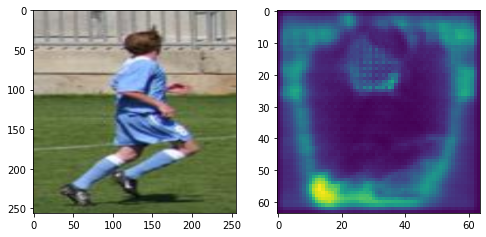

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.5070291982079407, 'head_top': 0.6947791164658634, 'neck': 0.7653575025176234, 'shoulder': 0.49710648148148145, 'elbow': 0.3794084186575654, 'wrist': 0.3364002300172513, 'ankle': 0.42901554404145076, 'knee': 0.4675324675324675, 'hip': 0.6782099094299414}
Classification metric 50:
{'all': 0.5071064421442917, 'head_top': 0.6947791164658634, 'neck': 0.7653575025176234, 'shoulder': 0.49710648148148145, 'elbow': 0.3794084186575654, 'wrist': 0.3364002300172513, 'ankle': 0.4295336787564767, 'knee': 0.4675324675324675, 'hip': 0.6782099094299414}
Classification metric 75:
{'all': 0.5071064421442917, 'head_top': 0.6947791164658634, 'neck': 0.7653575025176234, 'shoulder': 0.49710648148148145, 'elbow': 0.3794084186575654, 'wrist': 0.3364002300172513, 'ankle': 0.4295336787564767, 'knee': 0.4675324675324675, 'hip': 0.6782099094299414}
Train Loss on epoch 2: 35.1652379748465
Val Loss on epoch 2: 26.199921131134033


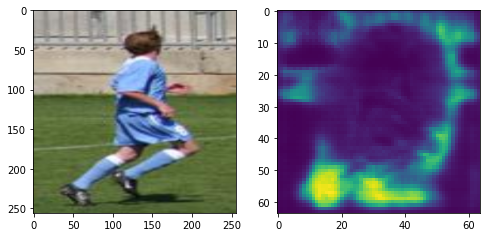

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.521551058241928, 'head_top': 0.7118473895582329, 'neck': 0.8096676737160121, 'shoulder': 0.5451388888888888, 'elbow': 0.3640500568828214, 'wrist': 0.2909718228867165, 'ankle': 0.4948186528497409, 'knee': 0.4664935064935065, 'hip': 0.6915290356952584}
Classification metric 50:
{'all': 0.521551058241928, 'head_top': 0.7118473895582329, 'neck': 0.8096676737160121, 'shoulder': 0.5451388888888888, 'elbow': 0.3640500568828214, 'wrist': 0.2909718228867165, 'ankle': 0.4948186528497409, 'knee': 0.4664935064935065, 'hip': 0.6915290356952584}
Classification metric 75:
{'all': 0.521551058241928, 'head_top': 0.7118473895582329, 'neck': 0.8096676737160121, 'shoulder': 0.5451388888888888, 'elbow': 0.3640500568828214, 'wrist': 0.2909718228867165, 'ankle': 0.4948186528497409, 'knee': 0.4664935064935065, 'hip': 0.6915290356952584}
Train Loss on epoch 3: 34.226383296922705
Val Loss on epoch 3: 25.50109076499939


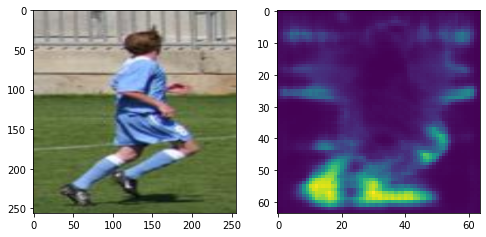

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Classification metric 25:
{'all': 0.5332148926309285, 'head_top': 0.7590361445783133, 'neck': 0.8187311178247734, 'shoulder': 0.5167824074074074, 'elbow': 0.3862343572241183, 'wrist': 0.32259919493962047, 'ankle': 0.4886010362694301, 'knee': 0.4722077922077922, 'hip': 0.7187000532765051}
Classification metric 50:
{'all': 0.5332148926309285, 'head_top': 0.7590361445783133, 'neck': 0.8187311178247734, 'shoulder': 0.5167824074074074, 'elbow': 0.3862343572241183, 'wrist': 0.32259919493962047, 'ankle': 0.4886010362694301, 'knee': 0.4722077922077922, 'hip': 0.7187000532765051}
Classification metric 75:
{'all': 0.5332148926309285, 'head_top': 0.7590361445783133, 'neck': 0.8187311178247734, 'shoulder': 0.5167824074074074, 'elbow': 0.3862343572241183, 'wrist': 0.32259919493962047, 'ankle': 0.4886010362694301, 'knee': 0.4722077922077922, 'hip': 0.7187000532765051}
Train Loss on epoch 4: 33.13958496882998
Val Loss on epoch 4: 24.64300298690796


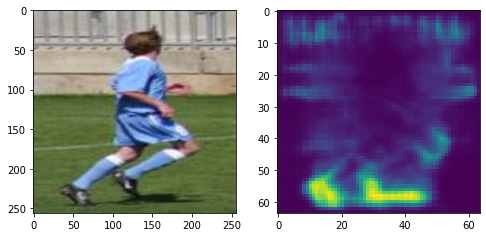

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Classification metric 25:
{'all': 0.5417889695658891, 'head_top': 0.8182730923694779, 'neck': 0.8439073514602216, 'shoulder': 0.5283564814814815, 'elbow': 0.4032992036405006, 'wrist': 0.2903967797584819, 'ankle': 0.4844559585492228, 'knee': 0.48467532467532465, 'hip': 0.7277570591369206}
Classification metric 50:
{'all': 0.5417117256295381, 'head_top': 0.8172690763052208, 'neck': 0.8439073514602216, 'shoulder': 0.5283564814814815, 'elbow': 0.4032992036405006, 'wrist': 0.2903967797584819, 'ankle': 0.4844559585492228, 'knee': 0.48467532467532465, 'hip': 0.7277570591369206}
Classification metric 75:
{'all': 0.5417117256295381, 'head_top': 0.8172690763052208, 'neck': 0.8439073514602216, 'shoulder': 0.5283564814814815, 'elbow': 0.4032992036405006, 'wrist': 0.2903967797584819, 'ankle': 0.4844559585492228, 'knee': 0.48467532467532465, 'hip': 0.7277570591369206}
Train Loss on epoch 5: 31.93081651884934
Val Loss on epoch 5: 23.626256465911865


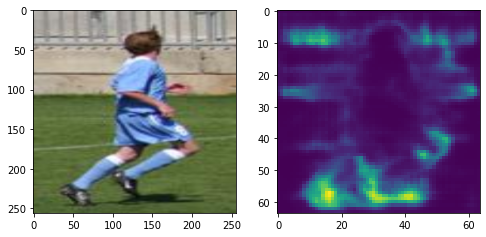

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.5536072918275915, 'head_top': 0.7971887550200804, 'neck': 0.8640483383685801, 'shoulder': 0.53125, 'elbow': 0.4402730375426621, 'wrist': 0.35135135135135137, 'ankle': 0.4948186528497409, 'knee': 0.4825974025974026, 'hip': 0.7075119872136388}
Classification metric 50:
{'all': 0.5534528039548895, 'head_top': 0.7971887550200804, 'neck': 0.8640483383685801, 'shoulder': 0.53125, 'elbow': 0.4402730375426621, 'wrist': 0.35135135135135137, 'ankle': 0.4937823834196891, 'knee': 0.4825974025974026, 'hip': 0.7075119872136388}
Classification metric 75:
{'all': 0.5534528039548895, 'head_top': 0.7971887550200804, 'neck': 0.8640483383685801, 'shoulder': 0.53125, 'elbow': 0.4402730375426621, 'wrist': 0.35135135135135137, 'ankle': 0.4937823834196891, 'knee': 0.4825974025974026, 'hip': 0.7075119872136388}
Train Loss on epoch 6: 31.009220693303252
Val Loss on epoch 6: 22.43102717399597


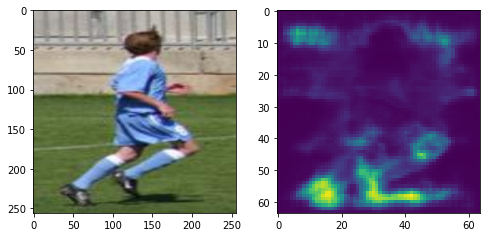

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5512127298007107, 'head_top': 0.7971887550200804, 'neck': 0.8580060422960725, 'shoulder': 0.5017361111111112, 'elbow': 0.4021615472127418, 'wrist': 0.37320299022426684, 'ankle': 0.5015544041450777, 'knee': 0.5075324675324675, 'hip': 0.7043153969099627}
Classification metric 50:
{'all': 0.5510582419280087, 'head_top': 0.7951807228915663, 'neck': 0.8580060422960725, 'shoulder': 0.5017361111111112, 'elbow': 0.4021615472127418, 'wrist': 0.37320299022426684, 'ankle': 0.5015544041450777, 'knee': 0.5075324675324675, 'hip': 0.7043153969099627}
Classification metric 75:
{'all': 0.5510582419280087, 'head_top': 0.7951807228915663, 'neck': 0.8580060422960725, 'shoulder': 0.5017361111111112, 'elbow': 0.4021615472127418, 'wrist': 0.37320299022426684, 'ankle': 0.5015544041450777, 'knee': 0.5075324675324675, 'hip': 0.7043153969099627}
Train Loss on epoch 7: 29.777872852895452
Val Loss on epoch 7: 21.122314453125


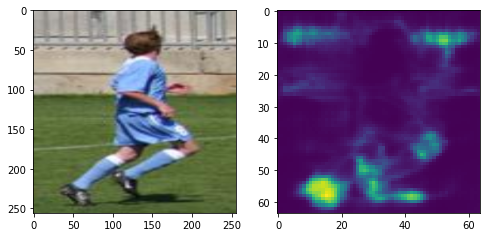

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5600185385447243, 'head_top': 0.8303212851405622, 'neck': 0.8680765357502518, 'shoulder': 0.5266203703703703, 'elbow': 0.40955631399317405, 'wrist': 0.38412880966072455, 'ankle': 0.4979274611398964, 'knee': 0.5132467532467533, 'hip': 0.7000532765050612}
Classification metric 50:
{'all': 0.5599412946083733, 'head_top': 0.8303212851405622, 'neck': 0.8680765357502518, 'shoulder': 0.5266203703703703, 'elbow': 0.40955631399317405, 'wrist': 0.38412880966072455, 'ankle': 0.4979274611398964, 'knee': 0.5127272727272727, 'hip': 0.7000532765050612}
Classification metric 75:
{'all': 0.5599412946083733, 'head_top': 0.8303212851405622, 'neck': 0.8680765357502518, 'shoulder': 0.5266203703703703, 'elbow': 0.40955631399317405, 'wrist': 0.38412880966072455, 'ankle': 0.4979274611398964, 'knee': 0.5127272727272727, 'hip': 0.7000532765050612}
Train Loss on epoch 8: 29.087890625
Val Loss on epoch 8: 20.52360725402832


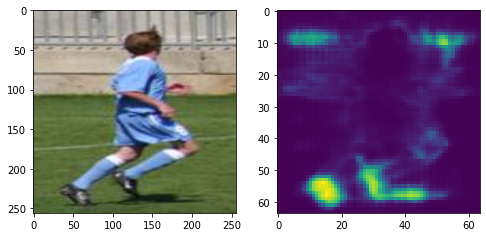

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5742314228333076, 'head_top': 0.8263052208835341, 'neck': 0.8710976837865055, 'shoulder': 0.5329861111111112, 'elbow': 0.4453924914675768, 'wrist': 0.36860264519838987, 'ankle': 0.5082901554404146, 'knee': 0.5392207792207793, 'hip': 0.7362812999467235}
Classification metric 50:
{'all': 0.5743086667696585, 'head_top': 0.8273092369477911, 'neck': 0.8710976837865055, 'shoulder': 0.5329861111111112, 'elbow': 0.4453924914675768, 'wrist': 0.36860264519838987, 'ankle': 0.5082901554404146, 'knee': 0.5392207792207793, 'hip': 0.7362812999467235}
Classification metric 75:
{'all': 0.5743086667696585, 'head_top': 0.8273092369477911, 'neck': 0.8710976837865055, 'shoulder': 0.5329861111111112, 'elbow': 0.4453924914675768, 'wrist': 0.36860264519838987, 'ankle': 0.5082901554404146, 'knee': 0.5392207792207793, 'hip': 0.7362812999467235}
Train Loss on epoch 9: 28.304449651433135
Val Loss on epoch 9: 19.9609055519104


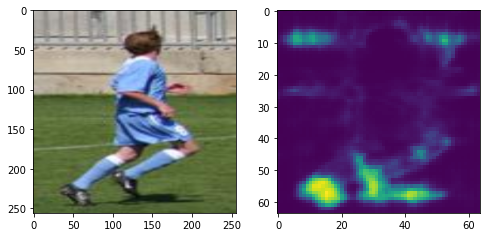

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Classification metric 25:
{'all': 0.585045573922447, 'head_top': 0.8172690763052208, 'neck': 0.8862034239677744, 'shoulder': 0.5914351851851852, 'elbow': 0.44368600682593856, 'wrist': 0.39160437032777456, 'ankle': 0.5072538860103627, 'knee': 0.5210389610389611, 'hip': 0.753862546616942}
Classification metric 50:
{'all': 0.584813842113394, 'head_top': 0.8142570281124498, 'neck': 0.8862034239677744, 'shoulder': 0.5914351851851852, 'elbow': 0.44368600682593856, 'wrist': 0.39160437032777456, 'ankle': 0.5072538860103627, 'knee': 0.5210389610389611, 'hip': 0.753862546616942}
Classification metric 75:
{'all': 0.584813842113394, 'head_top': 0.8142570281124498, 'neck': 0.8862034239677744, 'shoulder': 0.5914351851851852, 'elbow': 0.44368600682593856, 'wrist': 0.39160437032777456, 'ankle': 0.5072538860103627, 'knee': 0.5210389610389611, 'hip': 0.753862546616942}
Train Loss on epoch 10: 27.747555502529803
Val Loss on epoch 10: 19.342068672180176


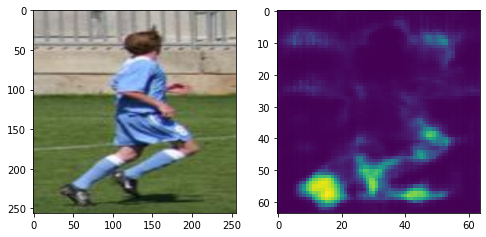

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5794840105051754, 'head_top': 0.7951807228915663, 'neck': 0.8559919436052367, 'shoulder': 0.5387731481481481, 'elbow': 0.43742889647326505, 'wrist': 0.4031052328924669, 'ankle': 0.5305699481865285, 'knee': 0.5288311688311689, 'hip': 0.7549280767181673}
Classification metric 50:
{'all': 0.5792522786961224, 'head_top': 0.7921686746987951, 'neck': 0.8559919436052367, 'shoulder': 0.5387731481481481, 'elbow': 0.43742889647326505, 'wrist': 0.4031052328924669, 'ankle': 0.5305699481865285, 'knee': 0.5288311688311689, 'hip': 0.7549280767181673}
Classification metric 75:
{'all': 0.5792522786961224, 'head_top': 0.7921686746987951, 'neck': 0.8559919436052367, 'shoulder': 0.5387731481481481, 'elbow': 0.43742889647326505, 'wrist': 0.4031052328924669, 'ankle': 0.5305699481865285, 'knee': 0.5288311688311689, 'hip': 0.7549280767181673}
Train Loss on epoch 11: 26.712387128808032
Val Loss on epoch 11: 19.25547957420349


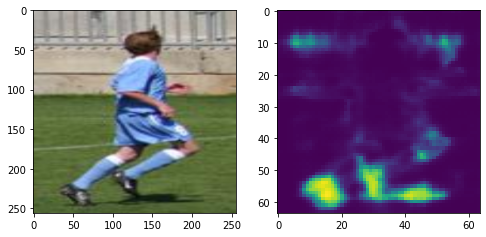

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Classification metric 25:
{'all': 0.5817240846593542, 'head_top': 0.785140562248996, 'neck': 0.8630412890231621, 'shoulder': 0.5260416666666666, 'elbow': 0.43856655290102387, 'wrist': 0.41345600920069003, 'ankle': 0.5341968911917099, 'knee': 0.5335064935064935, 'hip': 0.7645178476291955}
Classification metric 50:
{'all': 0.5815695967866522, 'head_top': 0.7831325301204819, 'neck': 0.8630412890231621, 'shoulder': 0.5260416666666666, 'elbow': 0.43856655290102387, 'wrist': 0.41345600920069003, 'ankle': 0.5341968911917099, 'knee': 0.5335064935064935, 'hip': 0.7645178476291955}
Classification metric 75:
{'all': 0.5814923528503012, 'head_top': 0.7821285140562249, 'neck': 0.8630412890231621, 'shoulder': 0.5260416666666666, 'elbow': 0.43856655290102387, 'wrist': 0.41345600920069003, 'ankle': 0.5341968911917099, 'knee': 0.5335064935064935, 'hip': 0.7645178476291955}
Train Loss on epoch 12: 25.951241811116535
Val Loss on epoch 12: 18.82805848121643


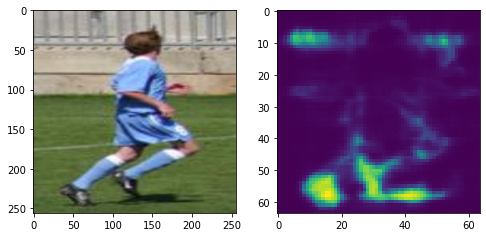

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Classification metric 25:
{'all': 0.5894484782944539, 'head_top': 0.8463855421686747, 'neck': 0.8892245720040282, 'shoulder': 0.5318287037037037, 'elbow': 0.4141069397042093, 'wrist': 0.42035652673950546, 'ankle': 0.5430051813471503, 'knee': 0.5542857142857143, 'hip': 0.7522642514651039}
Classification metric 50:
{'all': 0.5889850146763479, 'head_top': 0.8433734939759037, 'neck': 0.8882175226586103, 'shoulder': 0.5318287037037037, 'elbow': 0.4141069397042093, 'wrist': 0.4197814836112708, 'ankle': 0.5424870466321243, 'knee': 0.5542857142857143, 'hip': 0.7522642514651039}
Classification metric 75:
{'all': 0.5889850146763479, 'head_top': 0.8433734939759037, 'neck': 0.8882175226586103, 'shoulder': 0.5318287037037037, 'elbow': 0.4141069397042093, 'wrist': 0.4197814836112708, 'ankle': 0.5424870466321243, 'knee': 0.5542857142857143, 'hip': 0.7522642514651039}
Train Loss on epoch 13: 25.448088021113954
Val Loss on epoch 13: 18.169065237045288


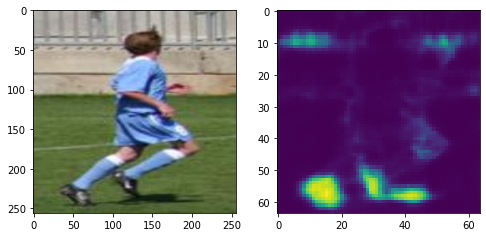

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5826510118955662, 'head_top': 0.8493975903614458, 'neck': 0.8841893252769386, 'shoulder': 0.5069444444444444, 'elbow': 0.4169510807736064, 'wrist': 0.4186313973548016, 'ankle': 0.5290155440414508, 'knee': 0.5475324675324675, 'hip': 0.7496004262120405}
Classification metric 50:
{'all': 0.5824192800865132, 'head_top': 0.8473895582329317, 'neck': 0.8831822759315207, 'shoulder': 0.5069444444444444, 'elbow': 0.4169510807736064, 'wrist': 0.4186313973548016, 'ankle': 0.5290155440414508, 'knee': 0.5475324675324675, 'hip': 0.7496004262120405}
Classification metric 75:
{'all': 0.5824192800865132, 'head_top': 0.8473895582329317, 'neck': 0.8831822759315207, 'shoulder': 0.5069444444444444, 'elbow': 0.4169510807736064, 'wrist': 0.4186313973548016, 'ankle': 0.5290155440414508, 'knee': 0.5475324675324675, 'hip': 0.7496004262120405}
Train Loss on epoch 14: 24.765455750213274
Val Loss on epoch 14: 18.040924072265625


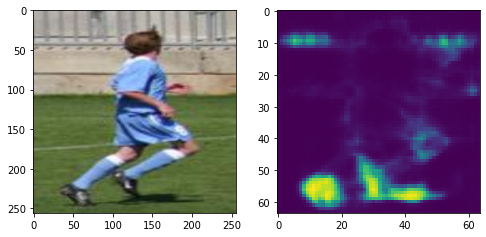

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5912250888305268, 'head_top': 0.8453815261044176, 'neck': 0.8972809667673716, 'shoulder': 0.5081018518518519, 'elbow': 0.4311717861205916, 'wrist': 0.4243818286371478, 'ankle': 0.5290155440414508, 'knee': 0.5761038961038961, 'hip': 0.7549280767181673}
Classification metric 50:
{'all': 0.5912250888305268, 'head_top': 0.8463855421686747, 'neck': 0.8962739174219537, 'shoulder': 0.5081018518518519, 'elbow': 0.4311717861205916, 'wrist': 0.4243818286371478, 'ankle': 0.5290155440414508, 'knee': 0.5761038961038961, 'hip': 0.7549280767181673}
Classification metric 75:
{'all': 0.5912250888305268, 'head_top': 0.8463855421686747, 'neck': 0.8962739174219537, 'shoulder': 0.5081018518518519, 'elbow': 0.4311717861205916, 'wrist': 0.4243818286371478, 'ankle': 0.5290155440414508, 'knee': 0.5761038961038961, 'hip': 0.7549280767181673}
Train Loss on epoch 15: 24.442185610190204
Val Loss on epoch 15: 17.547573566436768


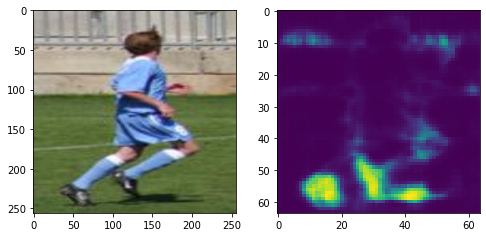

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.5806426695504403, 'head_top': 0.858433734939759, 'neck': 0.904330312185297, 'shoulder': 0.5, 'elbow': 0.4232081911262799, 'wrist': 0.437607820586544, 'ankle': 0.5186528497409326, 'knee': 0.5272727272727272, 'hip': 0.7346830047948855}
Classification metric 50:
{'all': 0.5805654256140893, 'head_top': 0.858433734939759, 'neck': 0.904330312185297, 'shoulder': 0.5, 'elbow': 0.4232081911262799, 'wrist': 0.4370327774583094, 'ankle': 0.5186528497409326, 'knee': 0.5272727272727272, 'hip': 0.7346830047948855}
Classification metric 75:
{'all': 0.5805654256140893, 'head_top': 0.858433734939759, 'neck': 0.904330312185297, 'shoulder': 0.5, 'elbow': 0.4232081911262799, 'wrist': 0.4370327774583094, 'ankle': 0.5186528497409326, 'knee': 0.5272727272727272, 'hip': 0.7346830047948855}
Train Loss on epoch 16: 23.829821378335186
Val Loss on epoch 16: 17.468324661254883


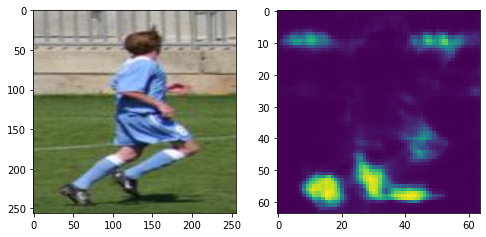

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.5985632627838715, 'head_top': 0.8674698795180723, 'neck': 0.9144008056394763, 'shoulder': 0.5625, 'elbow': 0.4499431171786121, 'wrist': 0.4479585968947671, 'ankle': 0.5373056994818652, 'knee': 0.535064935064935, 'hip': 0.728822589238146}
Classification metric 50:
{'all': 0.5984087749111695, 'head_top': 0.8664658634538153, 'neck': 0.9144008056394763, 'shoulder': 0.5625, 'elbow': 0.4499431171786121, 'wrist': 0.4479585968947671, 'ankle': 0.5367875647668394, 'knee': 0.535064935064935, 'hip': 0.728822589238146}
Classification metric 75:
{'all': 0.5984087749111695, 'head_top': 0.8664658634538153, 'neck': 0.9144008056394763, 'shoulder': 0.5625, 'elbow': 0.4499431171786121, 'wrist': 0.4479585968947671, 'ankle': 0.5367875647668394, 'knee': 0.535064935064935, 'hip': 0.728822589238146}
Train Loss on epoch 17: 23.383980213910682
Val Loss on epoch 17: 16.989441394805908


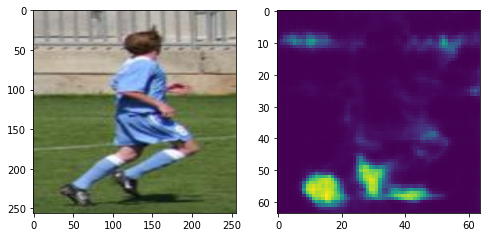

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6004171172562954, 'head_top': 0.8845381526104418, 'neck': 0.9264853977844915, 'shoulder': 0.5792824074074074, 'elbow': 0.44141069397042093, 'wrist': 0.45255894192064405, 'ankle': 0.5347150259067357, 'knee': 0.5194805194805194, 'hip': 0.7330847096430474}
Classification metric 50:
{'all': 0.6003398733199444, 'head_top': 0.8845381526104418, 'neck': 0.9264853977844915, 'shoulder': 0.5792824074074074, 'elbow': 0.44084186575654155, 'wrist': 0.45255894192064405, 'ankle': 0.5347150259067357, 'knee': 0.5194805194805194, 'hip': 0.7330847096430474}
Classification metric 75:
{'all': 0.6003398733199444, 'head_top': 0.8845381526104418, 'neck': 0.9264853977844915, 'shoulder': 0.5792824074074074, 'elbow': 0.44084186575654155, 'wrist': 0.45255894192064405, 'ankle': 0.5347150259067357, 'knee': 0.5194805194805194, 'hip': 0.7330847096430474}
Train Loss on epoch 18: 22.872088925591832
Val Loss on epoch 18: 16.84463119506836


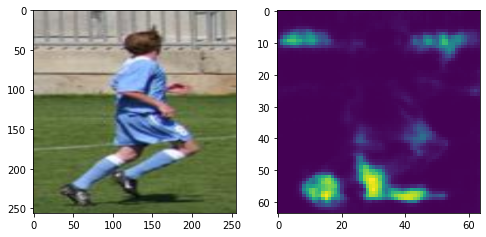

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.5946238220299707, 'head_top': 0.892570281124498, 'neck': 0.9284994964753273, 'shoulder': 0.5260416666666666, 'elbow': 0.431740614334471, 'wrist': 0.4485336400230017, 'ankle': 0.5419689119170984, 'knee': 0.5251948051948052, 'hip': 0.7362812999467235}
Classification metric 50:
{'all': 0.5946238220299707, 'head_top': 0.892570281124498, 'neck': 0.9284994964753273, 'shoulder': 0.5260416666666666, 'elbow': 0.431740614334471, 'wrist': 0.4485336400230017, 'ankle': 0.5419689119170984, 'knee': 0.5251948051948052, 'hip': 0.7362812999467235}
Classification metric 75:
{'all': 0.5946238220299707, 'head_top': 0.892570281124498, 'neck': 0.9284994964753273, 'shoulder': 0.5260416666666666, 'elbow': 0.431740614334471, 'wrist': 0.4485336400230017, 'ankle': 0.5419689119170984, 'knee': 0.5251948051948052, 'hip': 0.7362812999467235}
Train Loss on epoch 19: 22.392184904251977
Val Loss on epoch 19: 16.797623872756958


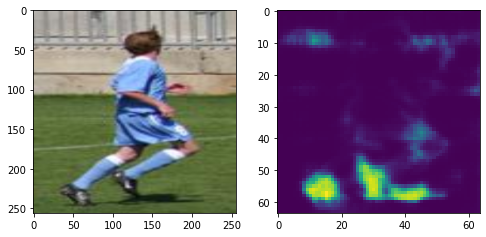

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.6059786806735671, 'head_top': 0.9116465863453815, 'neck': 0.9274924471299094, 'shoulder': 0.5763888888888888, 'elbow': 0.4539249146757679, 'wrist': 0.46520989074180563, 'ankle': 0.533160621761658, 'knee': 0.5106493506493507, 'hip': 0.7464038359083645}
Classification metric 50:
{'all': 0.6055152170554612, 'head_top': 0.9116465863453815, 'neck': 0.9274924471299094, 'shoulder': 0.5758101851851852, 'elbow': 0.4533560864618885, 'wrist': 0.46463484761357104, 'ankle': 0.5321243523316063, 'knee': 0.5106493506493507, 'hip': 0.7458710708577517}
Classification metric 75:
{'all': 0.6055152170554612, 'head_top': 0.9116465863453815, 'neck': 0.9274924471299094, 'shoulder': 0.5758101851851852, 'elbow': 0.4533560864618885, 'wrist': 0.46463484761357104, 'ankle': 0.5321243523316063, 'knee': 0.5106493506493507, 'hip': 0.7458710708577517}
Train Loss on epoch 20: 22.053703987735442
Val Loss on epoch 20: 16.47904145717621


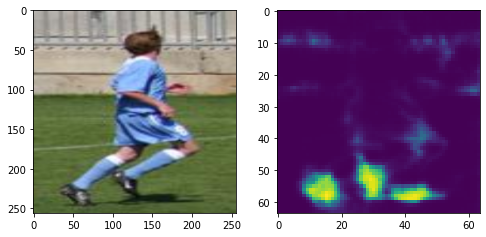

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6172562953808126, 'head_top': 0.9036144578313253, 'neck': 0.9315206445115811, 'shoulder': 0.5873842592592593, 'elbow': 0.4857792946530148, 'wrist': 0.4744105807935595, 'ankle': 0.5409326424870466, 'knee': 0.5397402597402597, 'hip': 0.7400106553010123}
Classification metric 50:
{'all': 0.6171018075081106, 'head_top': 0.9026104417670683, 'neck': 0.9315206445115811, 'shoulder': 0.5873842592592593, 'elbow': 0.4857792946530148, 'wrist': 0.4738355376653249, 'ankle': 0.5409326424870466, 'knee': 0.5397402597402597, 'hip': 0.7400106553010123}
Classification metric 75:
{'all': 0.6171018075081106, 'head_top': 0.9026104417670683, 'neck': 0.9315206445115811, 'shoulder': 0.5873842592592593, 'elbow': 0.4857792946530148, 'wrist': 0.4738355376653249, 'ankle': 0.5409326424870466, 'knee': 0.5397402597402597, 'hip': 0.7400106553010123}
Train Loss on epoch 21: 21.603269401637988
Val Loss on epoch 21: 16.14156413078308


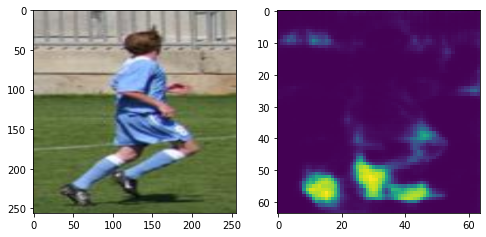

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.60852773057315, 'head_top': 0.9046184738955824, 'neck': 0.9345417925478349, 'shoulder': 0.5601851851851852, 'elbow': 0.47155858930602956, 'wrist': 0.4548591144335825, 'ankle': 0.5455958549222798, 'knee': 0.5376623376623376, 'hip': 0.7314864144912093}
Classification metric 50:
{'all': 0.608604974509501, 'head_top': 0.9046184738955824, 'neck': 0.9345417925478349, 'shoulder': 0.5601851851851852, 'elbow': 0.47155858930602956, 'wrist': 0.4548591144335825, 'ankle': 0.5455958549222798, 'knee': 0.5376623376623376, 'hip': 0.732019179541822}
Classification metric 75:
{'all': 0.608604974509501, 'head_top': 0.9046184738955824, 'neck': 0.9345417925478349, 'shoulder': 0.5601851851851852, 'elbow': 0.47155858930602956, 'wrist': 0.4548591144335825, 'ankle': 0.5455958549222798, 'knee': 0.5376623376623376, 'hip': 0.732019179541822}
Train Loss on epoch 22: 21.205020586649578
Val Loss on epoch 22: 16.115190744400024


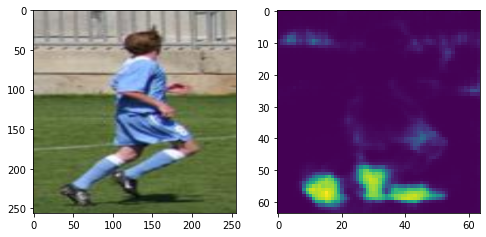

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Classification metric 25:
{'all': 0.607678047273289, 'head_top': 0.9116465863453815, 'neck': 0.9415911379657603, 'shoulder': 0.5584490740740741, 'elbow': 0.4681456200227531, 'wrist': 0.4686601495112133, 'ankle': 0.5424870466321243, 'knee': 0.5381818181818182, 'hip': 0.7128396377197656}
Classification metric 50:
{'all': 0.607600803336938, 'head_top': 0.9126506024096386, 'neck': 0.9405840886203424, 'shoulder': 0.5584490740740741, 'elbow': 0.4681456200227531, 'wrist': 0.46808510638297873, 'ankle': 0.5424870466321243, 'knee': 0.5381818181818182, 'hip': 0.7128396377197656}
Classification metric 75:
{'all': 0.607600803336938, 'head_top': 0.9126506024096386, 'neck': 0.9405840886203424, 'shoulder': 0.5584490740740741, 'elbow': 0.4681456200227531, 'wrist': 0.46808510638297873, 'ankle': 0.5424870466321243, 'knee': 0.5381818181818182, 'hip': 0.7128396377197656}
Train Loss on epoch 23: 21.042694201414612
Val Loss on epoch 23: 16.092832922935486


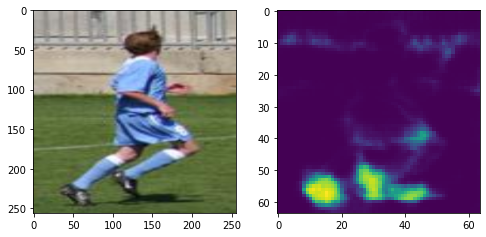

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Classification metric 25:
{'all': 0.6126989031361039, 'head_top': 0.9126506024096386, 'neck': 0.9335347432024169, 'shoulder': 0.546875, 'elbow': 0.46245733788395904, 'wrist': 0.4864864864864865, 'ankle': 0.5637305699481865, 'knee': 0.5433766233766234, 'hip': 0.7234949387320192}
Classification metric 50:
{'all': 0.6124671713270509, 'head_top': 0.9116465863453815, 'neck': 0.9335347432024169, 'shoulder': 0.546875, 'elbow': 0.46245733788395904, 'wrist': 0.48591144335825187, 'ankle': 0.5632124352331607, 'knee': 0.5433766233766234, 'hip': 0.7234949387320192}
Classification metric 75:
{'all': 0.6124671713270509, 'head_top': 0.9116465863453815, 'neck': 0.9335347432024169, 'shoulder': 0.546875, 'elbow': 0.46245733788395904, 'wrist': 0.48591144335825187, 'ankle': 0.5632124352331607, 'knee': 0.5433766233766234, 'hip': 0.7234949387320192}
Train Loss on epoch 24: 20.813883057956037
Val Loss on epoch 24: 16.00290012359619


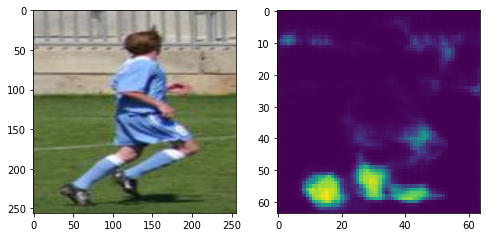

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Classification metric 25:
{'all': 0.6213502240074155, 'head_top': 0.9236947791164659, 'neck': 0.9506545820745217, 'shoulder': 0.5370370370370371, 'elbow': 0.4880546075085324, 'wrist': 0.47268545140885565, 'ankle': 0.5590673575129533, 'knee': 0.5542857142857143, 'hip': 0.7597229621736814}
Classification metric 50:
{'all': 0.6213502240074155, 'head_top': 0.9236947791164659, 'neck': 0.9506545820745217, 'shoulder': 0.5370370370370371, 'elbow': 0.4880546075085324, 'wrist': 0.4732604945370903, 'ankle': 0.5585492227979275, 'knee': 0.5542857142857143, 'hip': 0.7597229621736814}
Classification metric 75:
{'all': 0.6213502240074155, 'head_top': 0.9236947791164659, 'neck': 0.9506545820745217, 'shoulder': 0.5370370370370371, 'elbow': 0.4880546075085324, 'wrist': 0.4732604945370903, 'ankle': 0.5585492227979275, 'knee': 0.5542857142857143, 'hip': 0.7597229621736814}
Train Loss on epoch 25: 20.307613230299676
Val Loss on epoch 25: 15.64873218536377


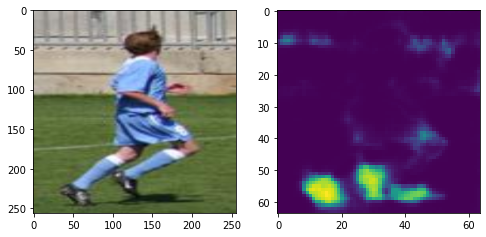

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.6148617333539317, 'head_top': 0.9206827309236948, 'neck': 0.9546827794561934, 'shoulder': 0.5358796296296297, 'elbow': 0.4613196814562002, 'wrist': 0.48878665899942497, 'ankle': 0.566321243523316, 'knee': 0.5361038961038961, 'hip': 0.7368140649973361}
Classification metric 50:
{'all': 0.6148617333539317, 'head_top': 0.9216867469879518, 'neck': 0.9546827794561934, 'shoulder': 0.5358796296296297, 'elbow': 0.4613196814562002, 'wrist': 0.48878665899942497, 'ankle': 0.5658031088082901, 'knee': 0.5361038961038961, 'hip': 0.7368140649973361}
Classification metric 75:
{'all': 0.6148617333539317, 'head_top': 0.9216867469879518, 'neck': 0.9546827794561934, 'shoulder': 0.5358796296296297, 'elbow': 0.4613196814562002, 'wrist': 0.48878665899942497, 'ankle': 0.5658031088082901, 'knee': 0.5361038961038961, 'hip': 0.7368140649973361}
Train Loss on epoch 26: 20.061777871230554
Val Loss on epoch 26: 15.698559045791626


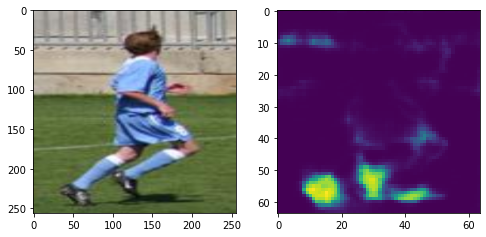

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6174880271898656, 'head_top': 0.9236947791164659, 'neck': 0.9486404833836858, 'shoulder': 0.5457175925925926, 'elbow': 0.47155858930602956, 'wrist': 0.48188614146060954, 'ankle': 0.5699481865284974, 'knee': 0.5335064935064935, 'hip': 0.7432072456046883}
Classification metric 50:
{'all': 0.6174107832535146, 'head_top': 0.9236947791164659, 'neck': 0.9486404833836858, 'shoulder': 0.5457175925925926, 'elbow': 0.47155858930602956, 'wrist': 0.48188614146060954, 'ankle': 0.5694300518134715, 'knee': 0.5335064935064935, 'hip': 0.7432072456046883}
Classification metric 75:
{'all': 0.6174107832535146, 'head_top': 0.9236947791164659, 'neck': 0.9486404833836858, 'shoulder': 0.5457175925925926, 'elbow': 0.47155858930602956, 'wrist': 0.48188614146060954, 'ankle': 0.5694300518134715, 'knee': 0.5335064935064935, 'hip': 0.7432072456046883}
Train Loss on epoch 27: 19.74698038210814
Val Loss on epoch 27: 15.334969878196716


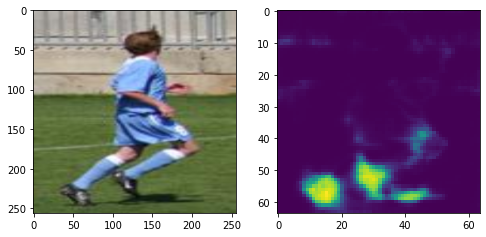

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6152479530356867, 'head_top': 0.927710843373494, 'neck': 0.9496475327291037, 'shoulder': 0.5104166666666666, 'elbow': 0.4863481228668942, 'wrist': 0.48303622771707877, 'ankle': 0.5580310880829016, 'knee': 0.5485714285714286, 'hip': 0.7394778902503996}
Classification metric 50:
{'all': 0.6152479530356867, 'head_top': 0.928714859437751, 'neck': 0.9496475327291037, 'shoulder': 0.5104166666666666, 'elbow': 0.4863481228668942, 'wrist': 0.48303622771707877, 'ankle': 0.5575129533678757, 'knee': 0.5485714285714286, 'hip': 0.7394778902503996}
Classification metric 75:
{'all': 0.6152479530356867, 'head_top': 0.928714859437751, 'neck': 0.9496475327291037, 'shoulder': 0.5104166666666666, 'elbow': 0.4863481228668942, 'wrist': 0.48303622771707877, 'ankle': 0.5575129533678757, 'knee': 0.5485714285714286, 'hip': 0.7394778902503996}
Train Loss on epoch 28: 19.43100415153065
Val Loss on epoch 28: 15.248417139053345


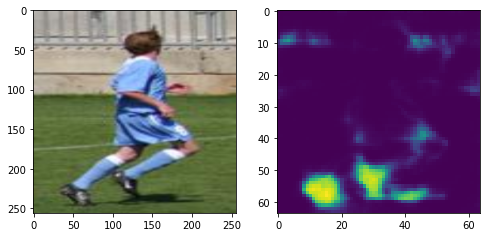

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6249806890159123, 'head_top': 0.9317269076305221, 'neck': 0.9556898288016112, 'shoulder': 0.5601851851851852, 'elbow': 0.4732650739476678, 'wrist': 0.484186313973548, 'ankle': 0.566839378238342, 'knee': 0.5605194805194805, 'hip': 0.745338305807139}
Classification metric 50:
{'all': 0.6249806890159123, 'head_top': 0.9317269076305221, 'neck': 0.9556898288016112, 'shoulder': 0.5601851851851852, 'elbow': 0.4738339021615472, 'wrist': 0.4836112708453134, 'ankle': 0.566839378238342, 'knee': 0.5605194805194805, 'hip': 0.745338305807139}
Classification metric 75:
{'all': 0.6249806890159123, 'head_top': 0.9317269076305221, 'neck': 0.9556898288016112, 'shoulder': 0.5601851851851852, 'elbow': 0.4738339021615472, 'wrist': 0.4836112708453134, 'ankle': 0.566839378238342, 'knee': 0.5605194805194805, 'hip': 0.745338305807139}
Train Loss on epoch 29: 19.190254310081745
Val Loss on epoch 29: 15.266536712646484


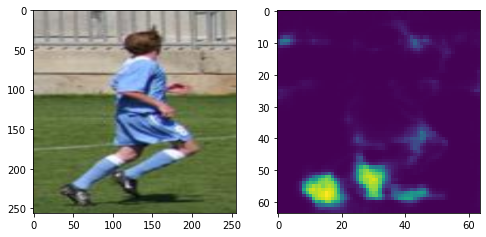

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6317781554148, 'head_top': 0.9347389558232931, 'neck': 0.9536757301107754, 'shoulder': 0.5729166666666666, 'elbow': 0.4988623435722412, 'wrist': 0.48016101207590567, 'ankle': 0.5601036269430052, 'knee': 0.5677922077922077, 'hip': 0.7591901971230687}
Classification metric 50:
{'all': 0.6317781554148, 'head_top': 0.9347389558232931, 'neck': 0.9536757301107754, 'shoulder': 0.5729166666666666, 'elbow': 0.4988623435722412, 'wrist': 0.48016101207590567, 'ankle': 0.5601036269430052, 'knee': 0.5677922077922077, 'hip': 0.7591901971230687}
Classification metric 75:
{'all': 0.6317781554148, 'head_top': 0.9347389558232931, 'neck': 0.9536757301107754, 'shoulder': 0.5729166666666666, 'elbow': 0.4988623435722412, 'wrist': 0.48016101207590567, 'ankle': 0.5601036269430052, 'knee': 0.5677922077922077, 'hip': 0.7591901971230687}
Train Loss on epoch 30: 18.98197111590155
Val Loss on epoch 30: 14.927637219429016


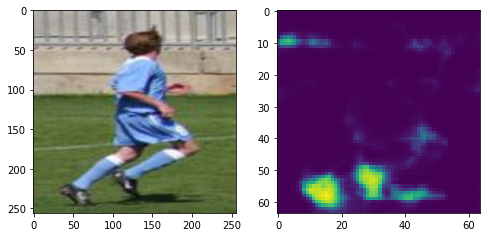

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6371079870230187, 'head_top': 0.9347389558232931, 'neck': 0.9526686807653575, 'shoulder': 0.5978009259259259, 'elbow': 0.4891922639362912, 'wrist': 0.5031627372052904, 'ankle': 0.5626943005181347, 'knee': 0.5693506493506494, 'hip': 0.757059136920618}
Classification metric 50:
{'all': 0.6371079870230187, 'head_top': 0.9347389558232931, 'neck': 0.9526686807653575, 'shoulder': 0.5978009259259259, 'elbow': 0.4891922639362912, 'wrist': 0.5031627372052904, 'ankle': 0.5626943005181347, 'knee': 0.5693506493506494, 'hip': 0.757059136920618}
Classification metric 75:
{'all': 0.6371079870230187, 'head_top': 0.9347389558232931, 'neck': 0.9526686807653575, 'shoulder': 0.5978009259259259, 'elbow': 0.4891922639362912, 'wrist': 0.5031627372052904, 'ankle': 0.5626943005181347, 'knee': 0.5693506493506494, 'hip': 0.757059136920618}
Train Loss on epoch 31: 18.714517132989293
Val Loss on epoch 31: 14.864205837249756


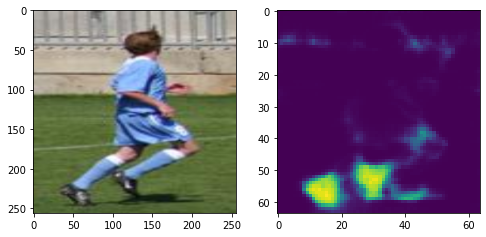

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6398887687316546, 'head_top': 0.928714859437751, 'neck': 0.9556898288016112, 'shoulder': 0.6024305555555556, 'elbow': 0.5045506257110353, 'wrist': 0.49568717653824035, 'ankle': 0.5595854922279793, 'knee': 0.5709090909090909, 'hip': 0.7677144379328716}
Classification metric 50:
{'all': 0.6398887687316546, 'head_top': 0.928714859437751, 'neck': 0.9556898288016112, 'shoulder': 0.6024305555555556, 'elbow': 0.5045506257110353, 'wrist': 0.49568717653824035, 'ankle': 0.5595854922279793, 'knee': 0.5709090909090909, 'hip': 0.7677144379328716}
Classification metric 75:
{'all': 0.6398887687316546, 'head_top': 0.928714859437751, 'neck': 0.9556898288016112, 'shoulder': 0.6024305555555556, 'elbow': 0.5045506257110353, 'wrist': 0.49568717653824035, 'ankle': 0.5595854922279793, 'knee': 0.5709090909090909, 'hip': 0.7677144379328716}
Train Loss on epoch 32: 18.38721564720417
Val Loss on epoch 32: 14.78448212146759


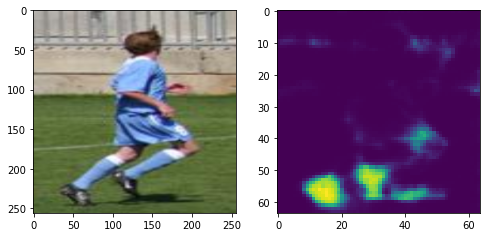

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Classification metric 25:
{'all': 0.6390390854317936, 'head_top': 0.9357429718875502, 'neck': 0.9617321248741189, 'shoulder': 0.5815972222222222, 'elbow': 0.5210466439135382, 'wrist': 0.515813686026452, 'ankle': 0.5606217616580311, 'knee': 0.5631168831168831, 'hip': 0.7469366009589771}
Classification metric 50:
{'all': 0.6389618414954427, 'head_top': 0.9357429718875502, 'neck': 0.9617321248741189, 'shoulder': 0.5815972222222222, 'elbow': 0.5210466439135382, 'wrist': 0.515813686026452, 'ankle': 0.5606217616580311, 'knee': 0.5625974025974027, 'hip': 0.7469366009589771}
Classification metric 75:
{'all': 0.6389618414954427, 'head_top': 0.9357429718875502, 'neck': 0.9617321248741189, 'shoulder': 0.5815972222222222, 'elbow': 0.5210466439135382, 'wrist': 0.515813686026452, 'ankle': 0.5606217616580311, 'knee': 0.5625974025974027, 'hip': 0.7469366009589771}
Train Loss on epoch 33: 18.22343773677431
Val Loss on epoch 33: 14.839716792106628


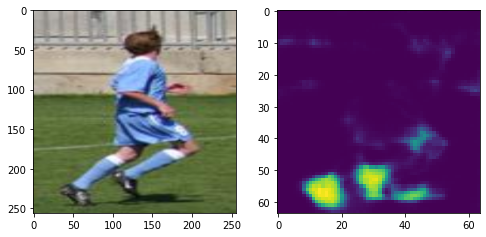

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Classification metric 25:
{'all': 0.6409701838405685, 'head_top': 0.929718875502008, 'neck': 0.9556898288016112, 'shoulder': 0.6267361111111112, 'elbow': 0.49772468714448237, 'wrist': 0.484186313973548, 'ankle': 0.5715025906735751, 'knee': 0.571948051948052, 'hip': 0.7559936068193926}
Classification metric 50:
{'all': 0.6408156959678665, 'head_top': 0.928714859437751, 'neck': 0.9556898288016112, 'shoulder': 0.6267361111111112, 'elbow': 0.49772468714448237, 'wrist': 0.484186313973548, 'ankle': 0.5715025906735751, 'knee': 0.5714285714285714, 'hip': 0.7559936068193926}
Classification metric 75:
{'all': 0.6408156959678665, 'head_top': 0.928714859437751, 'neck': 0.9556898288016112, 'shoulder': 0.6267361111111112, 'elbow': 0.49772468714448237, 'wrist': 0.484186313973548, 'ankle': 0.5715025906735751, 'knee': 0.5714285714285714, 'hip': 0.7559936068193926}
Train Loss on epoch 34: 18.077404603190807
Val Loss on epoch 34: 14.765885353088379


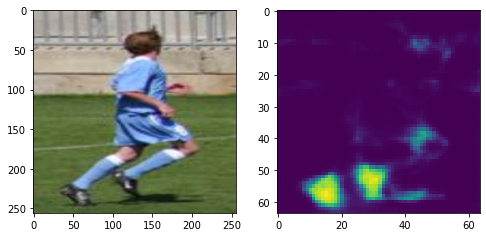

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Classification metric 25:
{'all': 0.6394253051135486, 'head_top': 0.9327309236947792, 'neck': 0.9566968781470292, 'shoulder': 0.6122685185185185, 'elbow': 0.5073947667804323, 'wrist': 0.4905117883841288, 'ankle': 0.5699481865284974, 'knee': 0.5724675324675325, 'hip': 0.7426744805540757}
Classification metric 50:
{'all': 0.6394253051135486, 'head_top': 0.9327309236947792, 'neck': 0.9566968781470292, 'shoulder': 0.6122685185185185, 'elbow': 0.5073947667804323, 'wrist': 0.4905117883841288, 'ankle': 0.5699481865284974, 'knee': 0.5724675324675325, 'hip': 0.7426744805540757}
Classification metric 75:
{'all': 0.6394253051135486, 'head_top': 0.9327309236947792, 'neck': 0.9566968781470292, 'shoulder': 0.6122685185185185, 'elbow': 0.5073947667804323, 'wrist': 0.4905117883841288, 'ankle': 0.5699481865284974, 'knee': 0.5724675324675325, 'hip': 0.7426744805540757}
Train Loss on epoch 35: 17.897763844194085
Val Loss on epoch 35: 14.748936653137207


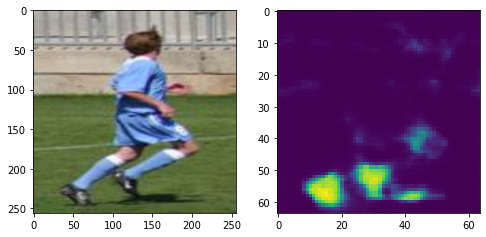

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6405839641588136, 'head_top': 0.927710843373494, 'neck': 0.9536757301107754, 'shoulder': 0.5862268518518519, 'elbow': 0.5073947667804323, 'wrist': 0.5083381253594019, 'ankle': 0.5704663212435234, 'knee': 0.5797402597402598, 'hip': 0.7543953116675546}
Classification metric 50:
{'all': 0.6406612080951646, 'head_top': 0.927710843373494, 'neck': 0.9536757301107754, 'shoulder': 0.5862268518518519, 'elbow': 0.5079635949943118, 'wrist': 0.5083381253594019, 'ankle': 0.5704663212435234, 'knee': 0.5797402597402598, 'hip': 0.7543953116675546}
Classification metric 75:
{'all': 0.6406612080951646, 'head_top': 0.927710843373494, 'neck': 0.9536757301107754, 'shoulder': 0.5862268518518519, 'elbow': 0.5079635949943118, 'wrist': 0.5083381253594019, 'ankle': 0.5704663212435234, 'knee': 0.5797402597402598, 'hip': 0.7543953116675546}
Train Loss on epoch 36: 17.641175346812982
Val Loss on epoch 36: 14.712107181549072


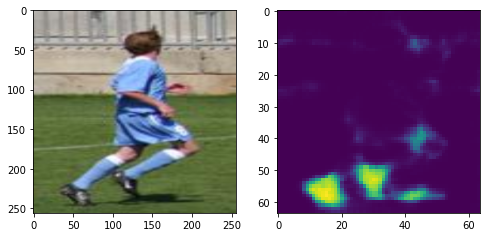

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6425923065039394, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5665509259259259, 'elbow': 0.5204778156996587, 'wrist': 0.496262219666475, 'ankle': 0.5787564766839378, 'knee': 0.5792207792207792, 'hip': 0.7677144379328716}
Classification metric 50:
{'all': 0.6424378186312375, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5665509259259259, 'elbow': 0.5204778156996587, 'wrist': 0.496262219666475, 'ankle': 0.5777202072538861, 'knee': 0.5792207792207792, 'hip': 0.7677144379328716}
Classification metric 75:
{'all': 0.6424378186312375, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5665509259259259, 'elbow': 0.5204778156996587, 'wrist': 0.496262219666475, 'ankle': 0.5777202072538861, 'knee': 0.5792207792207792, 'hip': 0.7677144379328716}
Train Loss on epoch 37: 17.50257551259008
Val Loss on epoch 37: 14.631437063217163


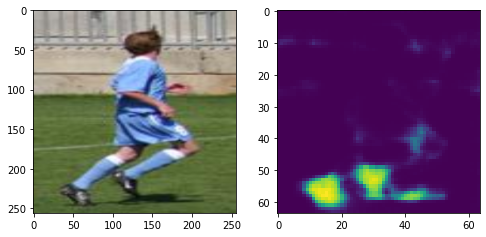

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Classification metric 25:
{'all': 0.629692569133323, 'head_top': 0.9317269076305221, 'neck': 0.9556898288016112, 'shoulder': 0.5358796296296297, 'elbow': 0.48976109215017066, 'wrist': 0.4974123059229442, 'ankle': 0.555440414507772, 'knee': 0.5875324675324676, 'hip': 0.7565263718700054}
Classification metric 50:
{'all': 0.629692569133323, 'head_top': 0.9317269076305221, 'neck': 0.9556898288016112, 'shoulder': 0.5358796296296297, 'elbow': 0.48976109215017066, 'wrist': 0.4974123059229442, 'ankle': 0.555440414507772, 'knee': 0.5875324675324676, 'hip': 0.7565263718700054}
Classification metric 75:
{'all': 0.629692569133323, 'head_top': 0.9317269076305221, 'neck': 0.9556898288016112, 'shoulder': 0.5358796296296297, 'elbow': 0.48976109215017066, 'wrist': 0.4974123059229442, 'ankle': 0.555440414507772, 'knee': 0.5875324675324676, 'hip': 0.7565263718700054}
Train Loss on epoch 38: 17.31832726796468
Val Loss on epoch 38: 14.651922702789307


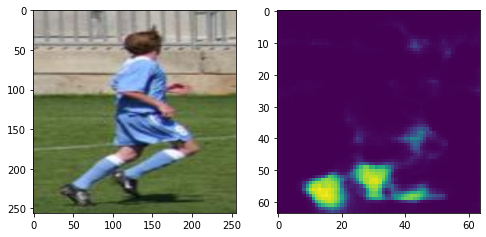

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6420515989494825, 'head_top': 0.9307228915662651, 'neck': 0.9617321248741189, 'shoulder': 0.5769675925925926, 'elbow': 0.5073947667804323, 'wrist': 0.491661874640598, 'ankle': 0.582901554404145, 'knee': 0.5911688311688311, 'hip': 0.7581246670218433}
Classification metric 50:
{'all': 0.6419743550131315, 'head_top': 0.9307228915662651, 'neck': 0.9617321248741189, 'shoulder': 0.5769675925925926, 'elbow': 0.5073947667804323, 'wrist': 0.491661874640598, 'ankle': 0.5823834196891192, 'knee': 0.5911688311688311, 'hip': 0.7581246670218433}
Classification metric 75:
{'all': 0.6419743550131315, 'head_top': 0.9307228915662651, 'neck': 0.9617321248741189, 'shoulder': 0.5769675925925926, 'elbow': 0.5073947667804323, 'wrist': 0.491661874640598, 'ankle': 0.5823834196891192, 'knee': 0.5911688311688311, 'hip': 0.7581246670218433}
Train Loss on epoch 39: 17.09057047175265
Val Loss on epoch 39: 14.522731304168701


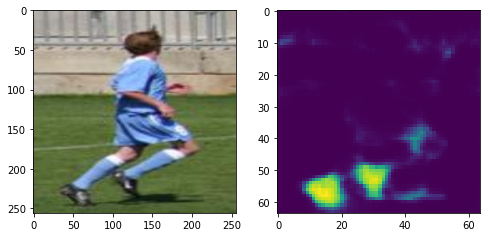

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6376486945774756, 'head_top': 0.9317269076305221, 'neck': 0.9607250755287009, 'shoulder': 0.5653935185185185, 'elbow': 0.5056882821387941, 'wrist': 0.5060379528464635, 'ankle': 0.5751295336787565, 'knee': 0.5864935064935065, 'hip': 0.7394778902503996}
Classification metric 50:
{'all': 0.6376486945774756, 'head_top': 0.9327309236947792, 'neck': 0.9607250755287009, 'shoulder': 0.5653935185185185, 'elbow': 0.5056882821387941, 'wrist': 0.5054629097182288, 'ankle': 0.5751295336787565, 'knee': 0.5864935064935065, 'hip': 0.7394778902503996}
Classification metric 75:
{'all': 0.6376486945774756, 'head_top': 0.9327309236947792, 'neck': 0.9607250755287009, 'shoulder': 0.5653935185185185, 'elbow': 0.5056882821387941, 'wrist': 0.5054629097182288, 'ankle': 0.5751295336787565, 'knee': 0.5864935064935065, 'hip': 0.7394778902503996}
Train Loss on epoch 40: 17.04864005384774
Val Loss on epoch 40: 14.351262211799622


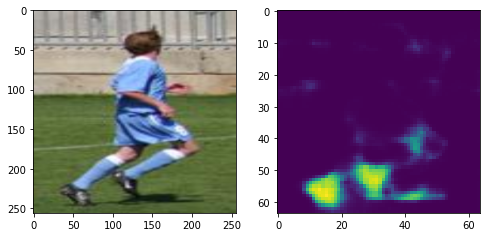

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6343272053143828, 'head_top': 0.9327309236947792, 'neck': 0.9577039274924471, 'shoulder': 0.5410879629629629, 'elbow': 0.4869169510807736, 'wrist': 0.5071880391029328, 'ankle': 0.5709844559585492, 'knee': 0.5818181818181818, 'hip': 0.7655833777304208}
Classification metric 50:
{'all': 0.6343272053143828, 'head_top': 0.9327309236947792, 'neck': 0.9577039274924471, 'shoulder': 0.5410879629629629, 'elbow': 0.4869169510807736, 'wrist': 0.5071880391029328, 'ankle': 0.5709844559585492, 'knee': 0.5818181818181818, 'hip': 0.7655833777304208}
Classification metric 75:
{'all': 0.6343272053143828, 'head_top': 0.9327309236947792, 'neck': 0.9577039274924471, 'shoulder': 0.5410879629629629, 'elbow': 0.4869169510807736, 'wrist': 0.5071880391029328, 'ankle': 0.5709844559585492, 'knee': 0.5818181818181818, 'hip': 0.7655833777304208}
Train Loss on epoch 41: 16.865534705677252
Val Loss on epoch 41: 14.49076235294342


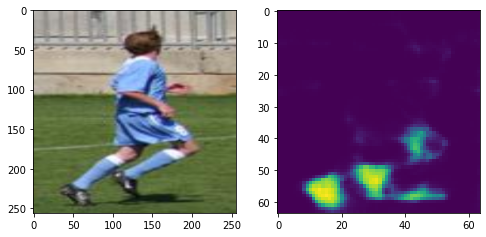

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Classification metric 25:
{'all': 0.6346361810597868, 'head_top': 0.927710843373494, 'neck': 0.9587109768378651, 'shoulder': 0.5561342592592593, 'elbow': 0.4789533560864619, 'wrist': 0.4864864864864865, 'ankle': 0.5704663212435234, 'knee': 0.6031168831168832, 'hip': 0.7613212573255195}
Classification metric 50:
{'all': 0.6347134249961378, 'head_top': 0.928714859437751, 'neck': 0.9587109768378651, 'shoulder': 0.5561342592592593, 'elbow': 0.4789533560864619, 'wrist': 0.4864864864864865, 'ankle': 0.5704663212435234, 'knee': 0.6031168831168832, 'hip': 0.7613212573255195}
Classification metric 75:
{'all': 0.6347134249961378, 'head_top': 0.928714859437751, 'neck': 0.9587109768378651, 'shoulder': 0.5561342592592593, 'elbow': 0.4789533560864619, 'wrist': 0.4864864864864865, 'ankle': 0.5704663212435234, 'knee': 0.6031168831168832, 'hip': 0.7613212573255195}
Train Loss on epoch 42: 16.7468876455022
Val Loss on epoch 42: 14.384159803390503


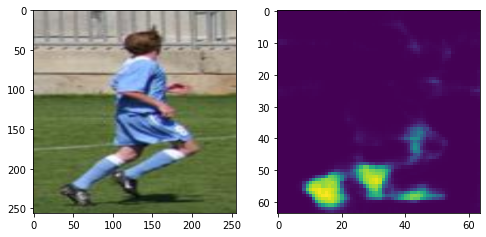

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6389618414954427, 'head_top': 0.9327309236947792, 'neck': 0.9637462235649547, 'shoulder': 0.5821759259259259, 'elbow': 0.4761092150170648, 'wrist': 0.49568717653824035, 'ankle': 0.5761658031088083, 'knee': 0.5963636363636363, 'hip': 0.757059136920618}
Classification metric 50:
{'all': 0.6390390854317936, 'head_top': 0.9337349397590361, 'neck': 0.9637462235649547, 'shoulder': 0.5821759259259259, 'elbow': 0.4761092150170648, 'wrist': 0.49568717653824035, 'ankle': 0.5761658031088083, 'knee': 0.5963636363636363, 'hip': 0.757059136920618}
Classification metric 75:
{'all': 0.6390390854317936, 'head_top': 0.9337349397590361, 'neck': 0.9637462235649547, 'shoulder': 0.5821759259259259, 'elbow': 0.4761092150170648, 'wrist': 0.49568717653824035, 'ankle': 0.5761658031088083, 'knee': 0.5963636363636363, 'hip': 0.757059136920618}
Train Loss on epoch 43: 16.603977334910425
Val Loss on epoch 43: 14.33116066455841


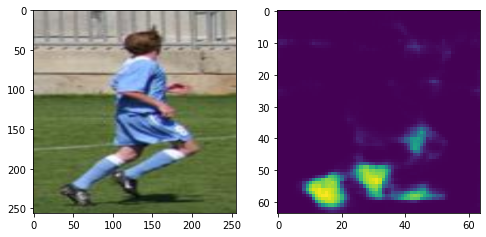

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6345589371234358, 'head_top': 0.9257028112449799, 'neck': 0.959718026183283, 'shoulder': 0.5769675925925926, 'elbow': 0.4943117178612059, 'wrist': 0.49798734905117886, 'ankle': 0.5709844559585492, 'knee': 0.5766233766233766, 'hip': 0.743740010655301}
Classification metric 50:
{'all': 0.6345589371234358, 'head_top': 0.9257028112449799, 'neck': 0.959718026183283, 'shoulder': 0.5769675925925926, 'elbow': 0.4943117178612059, 'wrist': 0.49798734905117886, 'ankle': 0.5709844559585492, 'knee': 0.5766233766233766, 'hip': 0.743740010655301}
Classification metric 75:
{'all': 0.6345589371234358, 'head_top': 0.9257028112449799, 'neck': 0.959718026183283, 'shoulder': 0.5769675925925926, 'elbow': 0.4943117178612059, 'wrist': 0.49798734905117886, 'ankle': 0.5709844559585492, 'knee': 0.5766233766233766, 'hip': 0.743740010655301}
Train Loss on epoch 44: 16.498772533460595
Val Loss on epoch 44: 14.418985605239868


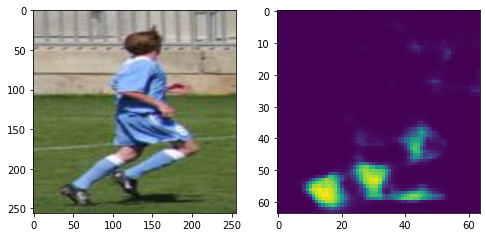

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.6422060868221845, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5833333333333334, 'elbow': 0.5039817974971559, 'wrist': 0.4991374353076481, 'ankle': 0.5766839378238342, 'knee': 0.5916883116883117, 'hip': 0.7511987213638786}
Classification metric 50:
{'all': 0.6422060868221845, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5833333333333334, 'elbow': 0.5039817974971559, 'wrist': 0.4991374353076481, 'ankle': 0.5766839378238342, 'knee': 0.5916883116883117, 'hip': 0.7511987213638786}
Classification metric 75:
{'all': 0.6422060868221845, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5833333333333334, 'elbow': 0.5039817974971559, 'wrist': 0.4991374353076481, 'ankle': 0.5766839378238342, 'knee': 0.5916883116883117, 'hip': 0.7511987213638786}
Train Loss on epoch 45: 16.392495659576067
Val Loss on epoch 45: 14.185092687606812


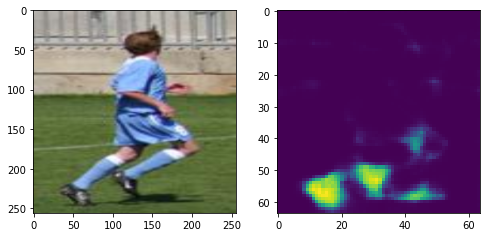

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Classification metric 25:
{'all': 0.6383438900046347, 'head_top': 0.9327309236947792, 'neck': 0.9617321248741189, 'shoulder': 0.5833333333333334, 'elbow': 0.4852104664391354, 'wrist': 0.4824611845888442, 'ankle': 0.5746113989637306, 'knee': 0.587012987012987, 'hip': 0.7677144379328716}
Classification metric 50:
{'all': 0.6383438900046347, 'head_top': 0.9327309236947792, 'neck': 0.9617321248741189, 'shoulder': 0.5833333333333334, 'elbow': 0.4852104664391354, 'wrist': 0.4824611845888442, 'ankle': 0.5746113989637306, 'knee': 0.587012987012987, 'hip': 0.7677144379328716}
Classification metric 75:
{'all': 0.6383438900046347, 'head_top': 0.9327309236947792, 'neck': 0.9617321248741189, 'shoulder': 0.5833333333333334, 'elbow': 0.4852104664391354, 'wrist': 0.4824611845888442, 'ankle': 0.5746113989637306, 'knee': 0.587012987012987, 'hip': 0.7677144379328716}
Train Loss on epoch 46: 16.271725424404803
Val Loss on epoch 46: 14.202991485595703


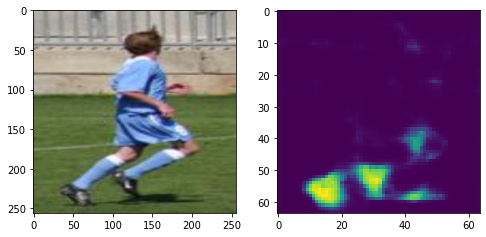

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6450641124671713, 'head_top': 0.9377510040160643, 'neck': 0.9587109768378651, 'shoulder': 0.5873842592592593, 'elbow': 0.48976109215017066, 'wrist': 0.5135135135135135, 'ankle': 0.5818652849740933, 'knee': 0.5948051948051948, 'hip': 0.7607884922749067}
Classification metric 50:
{'all': 0.6452186003398733, 'head_top': 0.9377510040160643, 'neck': 0.9587109768378651, 'shoulder': 0.5873842592592593, 'elbow': 0.48976109215017066, 'wrist': 0.5135135135135135, 'ankle': 0.5818652849740933, 'knee': 0.5948051948051948, 'hip': 0.7618540223761321}
Classification metric 75:
{'all': 0.6452186003398733, 'head_top': 0.9377510040160643, 'neck': 0.9587109768378651, 'shoulder': 0.5873842592592593, 'elbow': 0.48976109215017066, 'wrist': 0.5135135135135135, 'ankle': 0.5818652849740933, 'knee': 0.5948051948051948, 'hip': 0.7618540223761321}
Train Loss on epoch 47: 16.15170274931809
Val Loss on epoch 47: 14.20665693283081


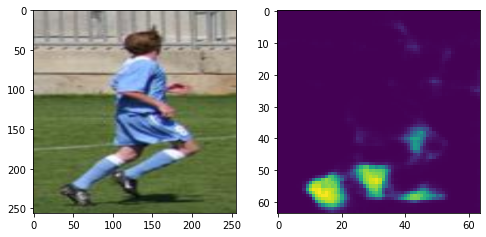

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Classification metric 25:
{'all': 0.6377259385138266, 'head_top': 0.9317269076305221, 'neck': 0.9617321248741189, 'shoulder': 0.5734953703703703, 'elbow': 0.48976109215017066, 'wrist': 0.5002875215641173, 'ankle': 0.572020725388601, 'knee': 0.5890909090909091, 'hip': 0.7527970165157166}
Classification metric 50:
{'all': 0.6377259385138266, 'head_top': 0.9317269076305221, 'neck': 0.9617321248741189, 'shoulder': 0.5734953703703703, 'elbow': 0.48976109215017066, 'wrist': 0.5002875215641173, 'ankle': 0.572020725388601, 'knee': 0.5890909090909091, 'hip': 0.7527970165157166}
Classification metric 75:
{'all': 0.6377259385138266, 'head_top': 0.9317269076305221, 'neck': 0.9617321248741189, 'shoulder': 0.5734953703703703, 'elbow': 0.48976109215017066, 'wrist': 0.5002875215641173, 'ankle': 0.572020725388601, 'knee': 0.5890909090909091, 'hip': 0.7527970165157166}
Train Loss on epoch 48: 16.05740617335528
Val Loss on epoch 48: 14.19478988647461


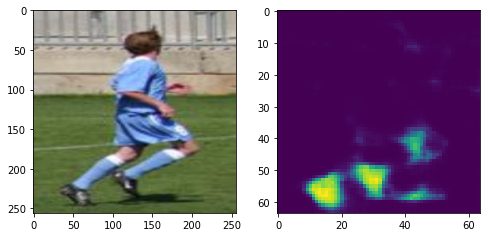

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6437509655492044, 'head_top': 0.9317269076305221, 'neck': 0.9667673716012085, 'shoulder': 0.5868055555555556, 'elbow': 0.5005688282138794, 'wrist': 0.496262219666475, 'ankle': 0.5772020725388601, 'knee': 0.5890909090909091, 'hip': 0.7677144379328716}
Classification metric 50:
{'all': 0.6438282094855554, 'head_top': 0.9317269076305221, 'neck': 0.9667673716012085, 'shoulder': 0.5868055555555556, 'elbow': 0.5005688282138794, 'wrist': 0.4968372627947096, 'ankle': 0.5772020725388601, 'knee': 0.5890909090909091, 'hip': 0.7677144379328716}
Classification metric 75:
{'all': 0.6438282094855554, 'head_top': 0.9317269076305221, 'neck': 0.9667673716012085, 'shoulder': 0.5868055555555556, 'elbow': 0.5005688282138794, 'wrist': 0.4968372627947096, 'ankle': 0.5772020725388601, 'knee': 0.5890909090909091, 'hip': 0.7677144379328716}
Train Loss on epoch 49: 15.924485524495443
Val Loss on epoch 49: 14.254674673080444


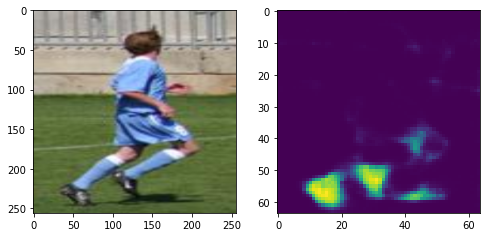

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6432102579947474, 'head_top': 0.929718875502008, 'neck': 0.9647532729103726, 'shoulder': 0.5839120370370371, 'elbow': 0.4948805460750853, 'wrist': 0.5071880391029328, 'ankle': 0.5751295336787565, 'knee': 0.5984415584415584, 'hip': 0.7565263718700054}
Classification metric 50:
{'all': 0.6432875019310984, 'head_top': 0.9307228915662651, 'neck': 0.9647532729103726, 'shoulder': 0.5839120370370371, 'elbow': 0.4948805460750853, 'wrist': 0.5071880391029328, 'ankle': 0.5751295336787565, 'knee': 0.5984415584415584, 'hip': 0.7565263718700054}
Classification metric 75:
{'all': 0.6432875019310984, 'head_top': 0.9307228915662651, 'neck': 0.9647532729103726, 'shoulder': 0.5839120370370371, 'elbow': 0.4948805460750853, 'wrist': 0.5071880391029328, 'ankle': 0.5751295336787565, 'knee': 0.5984415584415584, 'hip': 0.7565263718700054}
Train Loss on epoch 50: 15.810722789545169
Val Loss on epoch 50: 14.163856863975525


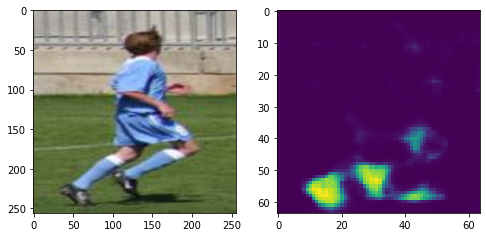

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6440599412946084, 'head_top': 0.9327309236947792, 'neck': 0.9657603222557906, 'shoulder': 0.5902777777777778, 'elbow': 0.5142207053469852, 'wrist': 0.5066129959746981, 'ankle': 0.5704663212435234, 'knee': 0.5838961038961039, 'hip': 0.7565263718700054}
Classification metric 50:
{'all': 0.6439826973582574, 'head_top': 0.9327309236947792, 'neck': 0.9657603222557906, 'shoulder': 0.5902777777777778, 'elbow': 0.5142207053469852, 'wrist': 0.5066129959746981, 'ankle': 0.5699481865284974, 'knee': 0.5838961038961039, 'hip': 0.7565263718700054}
Classification metric 75:
{'all': 0.6439826973582574, 'head_top': 0.9327309236947792, 'neck': 0.9657603222557906, 'shoulder': 0.5902777777777778, 'elbow': 0.5142207053469852, 'wrist': 0.5066129959746981, 'ankle': 0.5699481865284974, 'knee': 0.5838961038961039, 'hip': 0.7565263718700054}
Train Loss on epoch 51: 15.689479959422144
Val Loss on epoch 51: 14.177895784378052


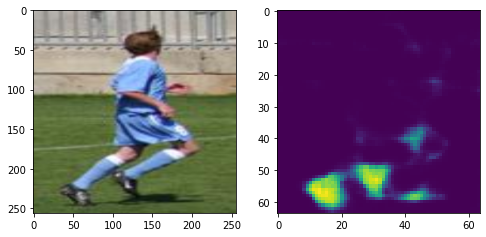

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6401205005407076, 'head_top': 0.9407630522088354, 'neck': 0.9677744209466264, 'shoulder': 0.5642361111111112, 'elbow': 0.5045506257110353, 'wrist': 0.4933870040253019, 'ankle': 0.5792746113989637, 'knee': 0.5854545454545454, 'hip': 0.7586574320724561}
Classification metric 50:
{'all': 0.6401205005407076, 'head_top': 0.9407630522088354, 'neck': 0.9677744209466264, 'shoulder': 0.5642361111111112, 'elbow': 0.5045506257110353, 'wrist': 0.4933870040253019, 'ankle': 0.5792746113989637, 'knee': 0.5854545454545454, 'hip': 0.7586574320724561}
Classification metric 75:
{'all': 0.6401205005407076, 'head_top': 0.9407630522088354, 'neck': 0.9677744209466264, 'shoulder': 0.5642361111111112, 'elbow': 0.5045506257110353, 'wrist': 0.4933870040253019, 'ankle': 0.5792746113989637, 'knee': 0.5854545454545454, 'hip': 0.7586574320724561}
Train Loss on epoch 52: 15.654001882706565
Val Loss on epoch 52: 14.204765558242798


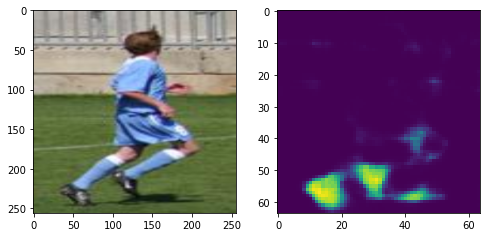

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6378031824501776, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5607638888888888, 'elbow': 0.5011376564277589, 'wrist': 0.503737780333525, 'ankle': 0.5658031088082901, 'knee': 0.5901298701298702, 'hip': 0.7533297815663292}
Classification metric 50:
{'all': 0.6378031824501776, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5607638888888888, 'elbow': 0.5011376564277589, 'wrist': 0.503737780333525, 'ankle': 0.5658031088082901, 'knee': 0.5901298701298702, 'hip': 0.7533297815663292}
Classification metric 75:
{'all': 0.6378031824501776, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5607638888888888, 'elbow': 0.5011376564277589, 'wrist': 0.503737780333525, 'ankle': 0.5658031088082901, 'knee': 0.5901298701298702, 'hip': 0.7533297815663292}
Train Loss on epoch 53: 15.467625245280649
Val Loss on epoch 53: 14.258751034736633


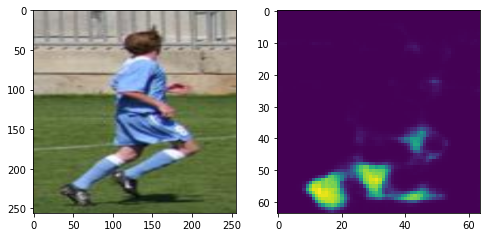

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6386528657500387, 'head_top': 0.9317269076305221, 'neck': 0.9637462235649547, 'shoulder': 0.5596064814814815, 'elbow': 0.49829351535836175, 'wrist': 0.5169637722829212, 'ankle': 0.5730569948186528, 'knee': 0.584935064935065, 'hip': 0.7506659563132658}
Classification metric 50:
{'all': 0.6386528657500387, 'head_top': 0.9317269076305221, 'neck': 0.9637462235649547, 'shoulder': 0.5596064814814815, 'elbow': 0.49829351535836175, 'wrist': 0.5169637722829212, 'ankle': 0.5730569948186528, 'knee': 0.584935064935065, 'hip': 0.7506659563132658}
Classification metric 75:
{'all': 0.6386528657500387, 'head_top': 0.9317269076305221, 'neck': 0.9637462235649547, 'shoulder': 0.5596064814814815, 'elbow': 0.49829351535836175, 'wrist': 0.5169637722829212, 'ankle': 0.5730569948186528, 'knee': 0.584935064935065, 'hip': 0.7506659563132658}
Train Loss on epoch 54: 15.492826856415848
Val Loss on epoch 54: 14.285614967346191


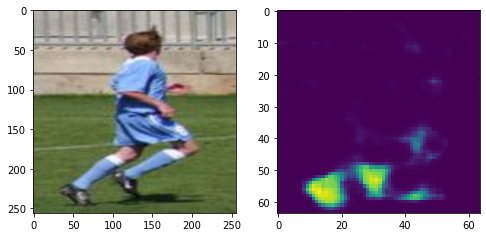

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Classification metric 25:
{'all': 0.6396570369226016, 'head_top': 0.9417670682730924, 'neck': 0.9687814702920443, 'shoulder': 0.5532407407407407, 'elbow': 0.5056882821387941, 'wrist': 0.5025876940770557, 'ankle': 0.5699481865284974, 'knee': 0.5942857142857143, 'hip': 0.7554608417687799}
Classification metric 50:
{'all': 0.6395797929862506, 'head_top': 0.9417670682730924, 'neck': 0.9687814702920443, 'shoulder': 0.5532407407407407, 'elbow': 0.5051194539249146, 'wrist': 0.5025876940770557, 'ankle': 0.5699481865284974, 'knee': 0.5942857142857143, 'hip': 0.7554608417687799}
Classification metric 75:
{'all': 0.6395797929862506, 'head_top': 0.9417670682730924, 'neck': 0.9687814702920443, 'shoulder': 0.5532407407407407, 'elbow': 0.5051194539249146, 'wrist': 0.5025876940770557, 'ankle': 0.5699481865284974, 'knee': 0.5942857142857143, 'hip': 0.7554608417687799}
Train Loss on epoch 55: 15.380983637667251
Val Loss on epoch 55: 14.143203020095825


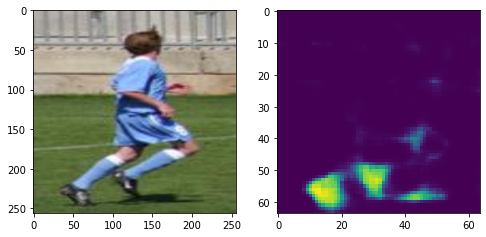

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6393480611771976, 'head_top': 0.9407630522088354, 'neck': 0.9647532729103726, 'shoulder': 0.5653935185185185, 'elbow': 0.5056882821387941, 'wrist': 0.5054629097182288, 'ankle': 0.5580310880829016, 'knee': 0.5989610389610389, 'hip': 0.7496004262120405}
Classification metric 50:
{'all': 0.6393480611771976, 'head_top': 0.9407630522088354, 'neck': 0.9647532729103726, 'shoulder': 0.5653935185185185, 'elbow': 0.5056882821387941, 'wrist': 0.5054629097182288, 'ankle': 0.5580310880829016, 'knee': 0.5989610389610389, 'hip': 0.7496004262120405}
Classification metric 75:
{'all': 0.6393480611771976, 'head_top': 0.9407630522088354, 'neck': 0.9647532729103726, 'shoulder': 0.5653935185185185, 'elbow': 0.5056882821387941, 'wrist': 0.5054629097182288, 'ankle': 0.5580310880829016, 'knee': 0.5989610389610389, 'hip': 0.7496004262120405}
Train Loss on epoch 56: 15.349021133335157
Val Loss on epoch 56: 14.202785730361938


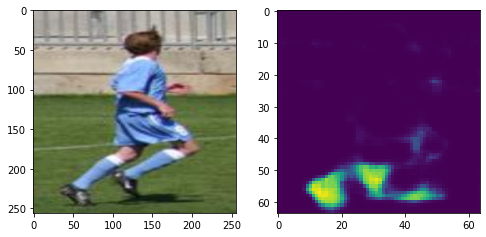

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Classification metric 25:
{'all': 0.6388845975590917, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5677083333333334, 'elbow': 0.5187713310580204, 'wrist': 0.4968372627947096, 'ankle': 0.5585492227979275, 'knee': 0.597922077922078, 'hip': 0.7432072456046883}
Classification metric 50:
{'all': 0.6388845975590917, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5677083333333334, 'elbow': 0.5187713310580204, 'wrist': 0.4968372627947096, 'ankle': 0.5585492227979275, 'knee': 0.597922077922078, 'hip': 0.7432072456046883}
Classification metric 75:
{'all': 0.6388845975590917, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5677083333333334, 'elbow': 0.5187713310580204, 'wrist': 0.4968372627947096, 'ankle': 0.5585492227979275, 'knee': 0.597922077922078, 'hip': 0.7432072456046883}
Train Loss on epoch 57: 15.230521191125629
Val Loss on epoch 57: 14.139273643493652


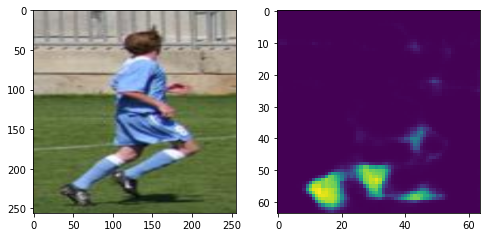

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6371079870230187, 'head_top': 0.9246987951807228, 'neck': 0.9617321248741189, 'shoulder': 0.5677083333333334, 'elbow': 0.5068259385665529, 'wrist': 0.5100632547441059, 'ankle': 0.5538860103626942, 'knee': 0.5968831168831169, 'hip': 0.7432072456046883}
Classification metric 50:
{'all': 0.6371852309593697, 'head_top': 0.9246987951807228, 'neck': 0.9617321248741189, 'shoulder': 0.5677083333333334, 'elbow': 0.5068259385665529, 'wrist': 0.5106382978723404, 'ankle': 0.5538860103626942, 'knee': 0.5968831168831169, 'hip': 0.7432072456046883}
Classification metric 75:
{'all': 0.6371852309593697, 'head_top': 0.9246987951807228, 'neck': 0.9617321248741189, 'shoulder': 0.5677083333333334, 'elbow': 0.5068259385665529, 'wrist': 0.5106382978723404, 'ankle': 0.5538860103626942, 'knee': 0.5968831168831169, 'hip': 0.7432072456046883}
Train Loss on epoch 58: 15.257602406644272
Val Loss on epoch 58: 14.223580837249756


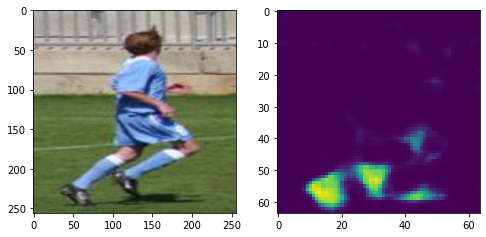

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6405067202224626, 'head_top': 0.9357429718875502, 'neck': 0.9718026183282981, 'shoulder': 0.5625, 'elbow': 0.5096700796359499, 'wrist': 0.5071880391029328, 'ankle': 0.5658031088082901, 'knee': 0.588051948051948, 'hip': 0.757059136920618}
Classification metric 50:
{'all': 0.6405067202224626, 'head_top': 0.9357429718875502, 'neck': 0.9718026183282981, 'shoulder': 0.5625, 'elbow': 0.5096700796359499, 'wrist': 0.5071880391029328, 'ankle': 0.5658031088082901, 'knee': 0.588051948051948, 'hip': 0.757059136920618}
Classification metric 75:
{'all': 0.6405067202224626, 'head_top': 0.9357429718875502, 'neck': 0.9718026183282981, 'shoulder': 0.5625, 'elbow': 0.5096700796359499, 'wrist': 0.5071880391029328, 'ankle': 0.5658031088082901, 'knee': 0.588051948051948, 'hip': 0.757059136920618}
Train Loss on epoch 59: 15.123090513821307
Val Loss on epoch 59: 14.196629881858826


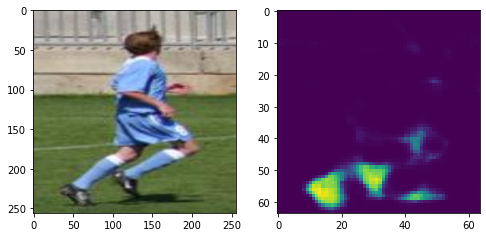

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6383438900046347, 'head_top': 0.9387550200803213, 'neck': 0.9657603222557906, 'shoulder': 0.5630787037037037, 'elbow': 0.5073947667804323, 'wrist': 0.49511213341000576, 'ankle': 0.5678756476683938, 'knee': 0.5932467532467532, 'hip': 0.7490676611614278}
Classification metric 50:
{'all': 0.6384211339409857, 'head_top': 0.9397590361445783, 'neck': 0.9657603222557906, 'shoulder': 0.5630787037037037, 'elbow': 0.5073947667804323, 'wrist': 0.49511213341000576, 'ankle': 0.5678756476683938, 'knee': 0.5932467532467532, 'hip': 0.7490676611614278}
Classification metric 75:
{'all': 0.6384211339409857, 'head_top': 0.9397590361445783, 'neck': 0.9657603222557906, 'shoulder': 0.5630787037037037, 'elbow': 0.5073947667804323, 'wrist': 0.49511213341000576, 'ankle': 0.5678756476683938, 'knee': 0.5932467532467532, 'hip': 0.7490676611614278}
Train Loss on epoch 60: 15.037183772558453
Val Loss on epoch 60: 14.127385258674622


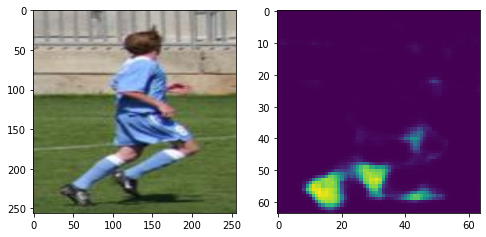

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6378804263865286, 'head_top': 0.9337349397590361, 'neck': 0.9667673716012085, 'shoulder': 0.5590277777777778, 'elbow': 0.5159271899886234, 'wrist': 0.48303622771707877, 'ankle': 0.5616580310880829, 'knee': 0.5984415584415584, 'hip': 0.7559936068193926}
Classification metric 50:
{'all': 0.6379576703228796, 'head_top': 0.9347389558232931, 'neck': 0.9667673716012085, 'shoulder': 0.5590277777777778, 'elbow': 0.5159271899886234, 'wrist': 0.48303622771707877, 'ankle': 0.5616580310880829, 'knee': 0.5984415584415584, 'hip': 0.7559936068193926}
Classification metric 75:
{'all': 0.6379576703228796, 'head_top': 0.9347389558232931, 'neck': 0.9667673716012085, 'shoulder': 0.5590277777777778, 'elbow': 0.5159271899886234, 'wrist': 0.48303622771707877, 'ankle': 0.5616580310880829, 'knee': 0.5984415584415584, 'hip': 0.7559936068193926}
Train Loss on epoch 61: 14.987305904256887
Val Loss on epoch 61: 14.18348228931427


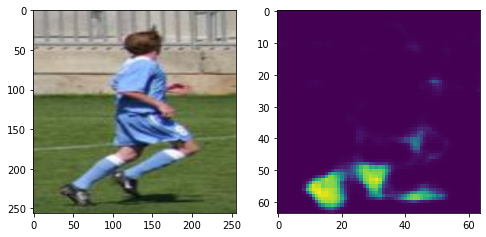

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6401205005407076, 'head_top': 0.9337349397590361, 'neck': 0.9667673716012085, 'shoulder': 0.5734953703703703, 'elbow': 0.4943117178612059, 'wrist': 0.5043128234617597, 'ankle': 0.5709844559585492, 'knee': 0.5932467532467532, 'hip': 0.7543953116675546}
Classification metric 50:
{'all': 0.6401205005407076, 'head_top': 0.9337349397590361, 'neck': 0.9667673716012085, 'shoulder': 0.5734953703703703, 'elbow': 0.4943117178612059, 'wrist': 0.5043128234617597, 'ankle': 0.5709844559585492, 'knee': 0.5932467532467532, 'hip': 0.7543953116675546}
Classification metric 75:
{'all': 0.6401205005407076, 'head_top': 0.9337349397590361, 'neck': 0.9667673716012085, 'shoulder': 0.5734953703703703, 'elbow': 0.4943117178612059, 'wrist': 0.5043128234617597, 'ankle': 0.5709844559585492, 'knee': 0.5932467532467532, 'hip': 0.7543953116675546}
Train Loss on epoch 62: 14.903427167870532
Val Loss on epoch 62: 14.140264749526978


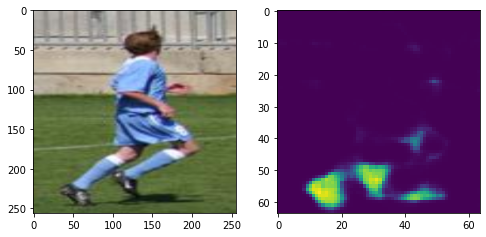

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6392708172408466, 'head_top': 0.9317269076305221, 'neck': 0.9677744209466264, 'shoulder': 0.5694444444444444, 'elbow': 0.5051194539249146, 'wrist': 0.5002875215641173, 'ankle': 0.5740932642487047, 'knee': 0.5890909090909091, 'hip': 0.7474693660095898}
Classification metric 50:
{'all': 0.6392708172408466, 'head_top': 0.9317269076305221, 'neck': 0.9677744209466264, 'shoulder': 0.5694444444444444, 'elbow': 0.5051194539249146, 'wrist': 0.5002875215641173, 'ankle': 0.5740932642487047, 'knee': 0.5890909090909091, 'hip': 0.7474693660095898}
Classification metric 75:
{'all': 0.6392708172408466, 'head_top': 0.9317269076305221, 'neck': 0.9677744209466264, 'shoulder': 0.5694444444444444, 'elbow': 0.5051194539249146, 'wrist': 0.5002875215641173, 'ankle': 0.5740932642487047, 'knee': 0.5890909090909091, 'hip': 0.7474693660095898}
Train Loss on epoch 63: 14.869776079024392
Val Loss on epoch 63: 14.139300346374512


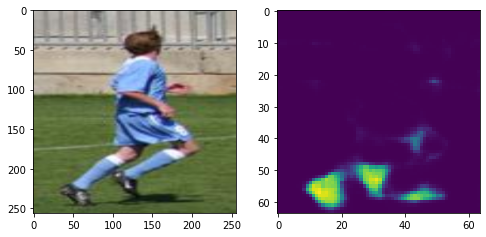

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6426695504402904, 'head_top': 0.9337349397590361, 'neck': 0.9707955689828801, 'shoulder': 0.5792824074074074, 'elbow': 0.5102389078498294, 'wrist': 0.503737780333525, 'ankle': 0.5704663212435234, 'knee': 0.5948051948051948, 'hip': 0.7490676611614278}
Classification metric 50:
{'all': 0.6426695504402904, 'head_top': 0.9337349397590361, 'neck': 0.9707955689828801, 'shoulder': 0.5792824074074074, 'elbow': 0.5102389078498294, 'wrist': 0.503737780333525, 'ankle': 0.5704663212435234, 'knee': 0.5948051948051948, 'hip': 0.7490676611614278}
Classification metric 75:
{'all': 0.6426695504402904, 'head_top': 0.9337349397590361, 'neck': 0.9707955689828801, 'shoulder': 0.5792824074074074, 'elbow': 0.5102389078498294, 'wrist': 0.503737780333525, 'ankle': 0.5704663212435234, 'knee': 0.5948051948051948, 'hip': 0.7490676611614278}
Train Loss on epoch 64: 14.83190523344895
Val Loss on epoch 64: 14.131294012069702


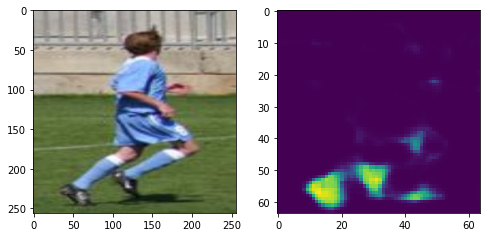

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Classification metric 25:
{'all': 0.6410474277769195, 'head_top': 0.9347389558232931, 'neck': 0.9657603222557906, 'shoulder': 0.5931712962962963, 'elbow': 0.5039817974971559, 'wrist': 0.49856239217941345, 'ankle': 0.555958549222798, 'knee': 0.5948051948051948, 'hip': 0.7527970165157166}
Classification metric 50:
{'all': 0.6412019156496215, 'head_top': 0.9367469879518072, 'neck': 0.9657603222557906, 'shoulder': 0.5931712962962963, 'elbow': 0.5039817974971559, 'wrist': 0.49856239217941345, 'ankle': 0.555958549222798, 'knee': 0.5948051948051948, 'hip': 0.7527970165157166}
Classification metric 75:
{'all': 0.6412019156496215, 'head_top': 0.9367469879518072, 'neck': 0.9657603222557906, 'shoulder': 0.5931712962962963, 'elbow': 0.5039817974971559, 'wrist': 0.49856239217941345, 'ankle': 0.555958549222798, 'knee': 0.5948051948051948, 'hip': 0.7527970165157166}
Train Loss on epoch 65: 14.790634593744388
Val Loss on epoch 65: 14.280323028564453


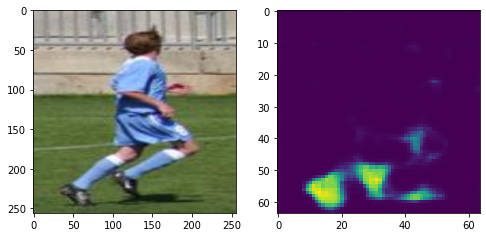

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6401977444770586, 'head_top': 0.9317269076305221, 'neck': 0.9677744209466264, 'shoulder': 0.5804398148148148, 'elbow': 0.5096700796359499, 'wrist': 0.5020126509488212, 'ankle': 0.5642487046632124, 'knee': 0.5859740259740259, 'hip': 0.7511987213638786}
Classification metric 50:
{'all': 0.6401977444770586, 'head_top': 0.9317269076305221, 'neck': 0.9677744209466264, 'shoulder': 0.5804398148148148, 'elbow': 0.5096700796359499, 'wrist': 0.5020126509488212, 'ankle': 0.5642487046632124, 'knee': 0.5859740259740259, 'hip': 0.7511987213638786}
Classification metric 75:
{'all': 0.6401977444770586, 'head_top': 0.9317269076305221, 'neck': 0.9677744209466264, 'shoulder': 0.5804398148148148, 'elbow': 0.5096700796359499, 'wrist': 0.5020126509488212, 'ankle': 0.5642487046632124, 'knee': 0.5859740259740259, 'hip': 0.7511987213638786}
Train Loss on epoch 66: 14.767203363878973
Val Loss on epoch 66: 14.12658166885376


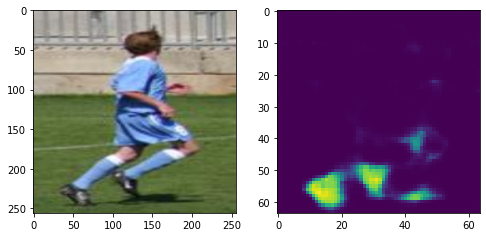

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6405067202224626, 'head_top': 0.9367469879518072, 'neck': 0.9647532729103726, 'shoulder': 0.5810185185185185, 'elbow': 0.49715585893060293, 'wrist': 0.4997124784358827, 'ankle': 0.5683937823834196, 'knee': 0.5958441558441558, 'hip': 0.7511987213638786}
Classification metric 50:
{'all': 0.6405839641588136, 'head_top': 0.9367469879518072, 'neck': 0.9647532729103726, 'shoulder': 0.5810185185185185, 'elbow': 0.49715585893060293, 'wrist': 0.5002875215641173, 'ankle': 0.5683937823834196, 'knee': 0.5958441558441558, 'hip': 0.7511987213638786}
Classification metric 75:
{'all': 0.6405839641588136, 'head_top': 0.9367469879518072, 'neck': 0.9647532729103726, 'shoulder': 0.5810185185185185, 'elbow': 0.49715585893060293, 'wrist': 0.5002875215641173, 'ankle': 0.5683937823834196, 'knee': 0.5958441558441558, 'hip': 0.7511987213638786}
Train Loss on epoch 67: 14.701778795527316
Val Loss on epoch 67: 14.193858027458191


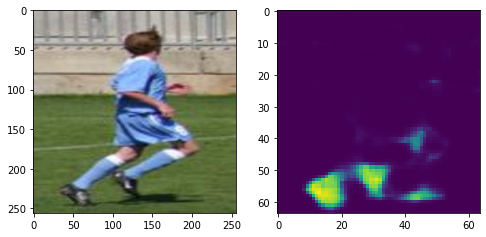

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Classification metric 25:
{'all': 0.6414336474586745, 'head_top': 0.9337349397590361, 'neck': 0.9647532729103726, 'shoulder': 0.5978009259259259, 'elbow': 0.5005688282138794, 'wrist': 0.4968372627947096, 'ankle': 0.561139896373057, 'knee': 0.5906493506493506, 'hip': 0.7559936068193926}
Classification metric 50:
{'all': 0.6415108913950255, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5978009259259259, 'elbow': 0.5005688282138794, 'wrist': 0.4968372627947096, 'ankle': 0.561139896373057, 'knee': 0.5906493506493506, 'hip': 0.7559936068193926}
Classification metric 75:
{'all': 0.6415108913950255, 'head_top': 0.9347389558232931, 'neck': 0.9647532729103726, 'shoulder': 0.5978009259259259, 'elbow': 0.5005688282138794, 'wrist': 0.4968372627947096, 'ankle': 0.561139896373057, 'knee': 0.5906493506493506, 'hip': 0.7559936068193926}
Train Loss on epoch 68: 14.629441721686002
Val Loss on epoch 68: 14.12647259235382


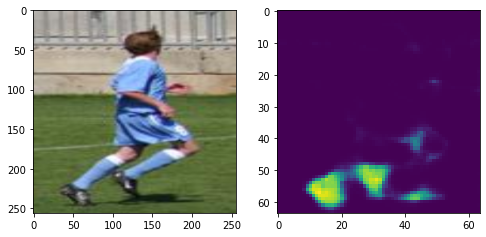

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6435964776765024, 'head_top': 0.9317269076305221, 'neck': 0.9667673716012085, 'shoulder': 0.5792824074074074, 'elbow': 0.5045506257110353, 'wrist': 0.5048878665899943, 'ankle': 0.5756476683937823, 'knee': 0.5906493506493506, 'hip': 0.7618540223761321}
Classification metric 50:
{'all': 0.6435964776765024, 'head_top': 0.9317269076305221, 'neck': 0.9667673716012085, 'shoulder': 0.5792824074074074, 'elbow': 0.5045506257110353, 'wrist': 0.5048878665899943, 'ankle': 0.5756476683937823, 'knee': 0.5906493506493506, 'hip': 0.7618540223761321}
Classification metric 75:
{'all': 0.6435964776765024, 'head_top': 0.9317269076305221, 'neck': 0.9667673716012085, 'shoulder': 0.5792824074074074, 'elbow': 0.5045506257110353, 'wrist': 0.5048878665899943, 'ankle': 0.5756476683937823, 'knee': 0.5906493506493506, 'hip': 0.7618540223761321}
Train Loss on epoch 69: 14.57557490776325
Val Loss on epoch 69: 14.18642282485962


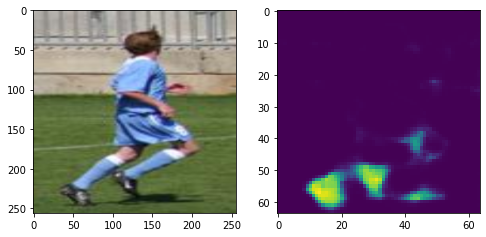

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6425923065039394, 'head_top': 0.9327309236947792, 'neck': 0.9647532729103726, 'shoulder': 0.5833333333333334, 'elbow': 0.512514220705347, 'wrist': 0.5020126509488212, 'ankle': 0.5740932642487047, 'knee': 0.5922077922077922, 'hip': 0.7469366009589771}
Classification metric 50:
{'all': 0.6425923065039394, 'head_top': 0.9327309236947792, 'neck': 0.9647532729103726, 'shoulder': 0.5833333333333334, 'elbow': 0.512514220705347, 'wrist': 0.5020126509488212, 'ankle': 0.5740932642487047, 'knee': 0.5922077922077922, 'hip': 0.7469366009589771}
Classification metric 75:
{'all': 0.6425150625675884, 'head_top': 0.9317269076305221, 'neck': 0.9647532729103726, 'shoulder': 0.5833333333333334, 'elbow': 0.512514220705347, 'wrist': 0.5020126509488212, 'ankle': 0.5740932642487047, 'knee': 0.5922077922077922, 'hip': 0.7469366009589771}
Train Loss on epoch 70: 14.575241987732635
Val Loss on epoch 70: 14.185161828994751


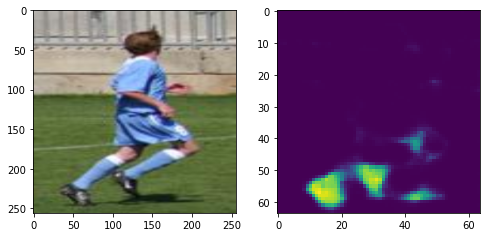

100%|██████████| 8/8 [00:06<00:00,  1.14it/s]


Classification metric 25:
{'all': 0.6420515989494825, 'head_top': 0.9357429718875502, 'neck': 0.9677744209466264, 'shoulder': 0.5694444444444444, 'elbow': 0.5068259385665529, 'wrist': 0.5106382978723404, 'ankle': 0.5751295336787565, 'knee': 0.5896103896103896, 'hip': 0.7517314864144912}
Classification metric 50:
{'all': 0.6420515989494825, 'head_top': 0.9357429718875502, 'neck': 0.9677744209466264, 'shoulder': 0.5694444444444444, 'elbow': 0.5068259385665529, 'wrist': 0.5106382978723404, 'ankle': 0.5751295336787565, 'knee': 0.5896103896103896, 'hip': 0.7517314864144912}
Classification metric 75:
{'all': 0.6420515989494825, 'head_top': 0.9357429718875502, 'neck': 0.9677744209466264, 'shoulder': 0.5694444444444444, 'elbow': 0.5068259385665529, 'wrist': 0.5106382978723404, 'ankle': 0.5751295336787565, 'knee': 0.5896103896103896, 'hip': 0.7517314864144912}
Train Loss on epoch 71: 14.514659136191181
Val Loss on epoch 71: 14.210651993751526


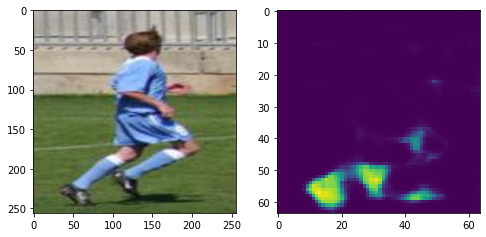

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6427467943766414, 'head_top': 0.927710843373494, 'neck': 0.9647532729103726, 'shoulder': 0.5827546296296297, 'elbow': 0.5091012514220705, 'wrist': 0.5054629097182288, 'ankle': 0.566839378238342, 'knee': 0.5958441558441558, 'hip': 0.7549280767181673}
Classification metric 50:
{'all': 0.6427467943766414, 'head_top': 0.927710843373494, 'neck': 0.9647532729103726, 'shoulder': 0.5827546296296297, 'elbow': 0.5091012514220705, 'wrist': 0.5054629097182288, 'ankle': 0.566839378238342, 'knee': 0.5958441558441558, 'hip': 0.7549280767181673}
Classification metric 75:
{'all': 0.6427467943766414, 'head_top': 0.927710843373494, 'neck': 0.9647532729103726, 'shoulder': 0.5827546296296297, 'elbow': 0.5091012514220705, 'wrist': 0.5054629097182288, 'ankle': 0.566839378238342, 'knee': 0.5958441558441558, 'hip': 0.7549280767181673}
Train Loss on epoch 72: 14.533202050746173
Val Loss on epoch 72: 14.136338233947754


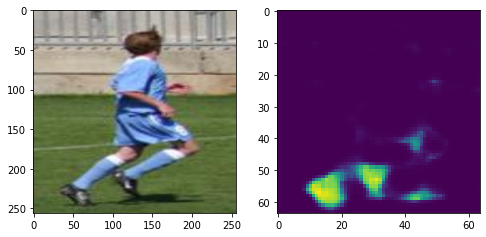

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6417426232040785, 'head_top': 0.9347389558232931, 'neck': 0.9667673716012085, 'shoulder': 0.5821759259259259, 'elbow': 0.5051194539249146, 'wrist': 0.5008625646923519, 'ankle': 0.5730569948186528, 'knee': 0.5916883116883117, 'hip': 0.7496004262120405}
Classification metric 50:
{'all': 0.6417426232040785, 'head_top': 0.9347389558232931, 'neck': 0.9667673716012085, 'shoulder': 0.5821759259259259, 'elbow': 0.5051194539249146, 'wrist': 0.5008625646923519, 'ankle': 0.5730569948186528, 'knee': 0.5916883116883117, 'hip': 0.7496004262120405}
Classification metric 75:
{'all': 0.6418198671404295, 'head_top': 0.9357429718875502, 'neck': 0.9667673716012085, 'shoulder': 0.5821759259259259, 'elbow': 0.5051194539249146, 'wrist': 0.5008625646923519, 'ankle': 0.5730569948186528, 'knee': 0.5916883116883117, 'hip': 0.7496004262120405}
Train Loss on epoch 73: 14.445216551594351
Val Loss on epoch 73: 14.22231113910675


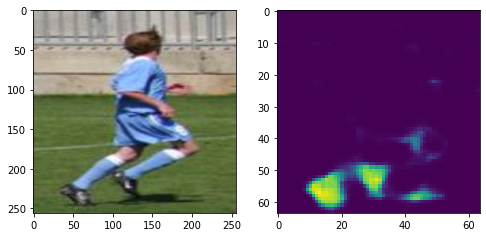

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6397342808589526, 'head_top': 0.927710843373494, 'neck': 0.9667673716012085, 'shoulder': 0.5925925925925926, 'elbow': 0.5039817974971559, 'wrist': 0.4991374353076481, 'ankle': 0.5606217616580311, 'knee': 0.5885714285714285, 'hip': 0.7485348961108151}
Classification metric 50:
{'all': 0.6398887687316546, 'head_top': 0.928714859437751, 'neck': 0.9677744209466264, 'shoulder': 0.5925925925925926, 'elbow': 0.5039817974971559, 'wrist': 0.4991374353076481, 'ankle': 0.5606217616580311, 'knee': 0.5885714285714285, 'hip': 0.7485348961108151}
Classification metric 75:
{'all': 0.6398887687316546, 'head_top': 0.928714859437751, 'neck': 0.9677744209466264, 'shoulder': 0.5925925925925926, 'elbow': 0.5039817974971559, 'wrist': 0.4991374353076481, 'ankle': 0.5606217616580311, 'knee': 0.5885714285714285, 'hip': 0.7485348961108151}
Train Loss on epoch 74: 14.435623826651737
Val Loss on epoch 74: 14.163554668426514


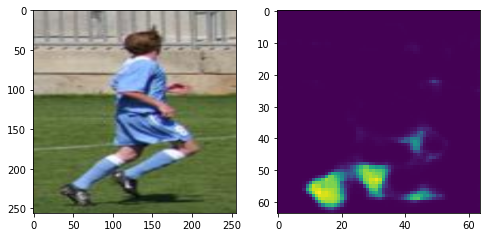

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Classification metric 25:
{'all': 0.6441371852309594, 'head_top': 0.9347389558232931, 'neck': 0.9697885196374623, 'shoulder': 0.59375, 'elbow': 0.5011376564277589, 'wrist': 0.5043128234617597, 'ankle': 0.572538860103627, 'knee': 0.5937662337662337, 'hip': 0.7527970165157166}
Classification metric 50:
{'all': 0.6440599412946084, 'head_top': 0.9337349397590361, 'neck': 0.9697885196374623, 'shoulder': 0.59375, 'elbow': 0.5011376564277589, 'wrist': 0.5043128234617597, 'ankle': 0.572538860103627, 'knee': 0.5937662337662337, 'hip': 0.7527970165157166}
Classification metric 75:
{'all': 0.6440599412946084, 'head_top': 0.9337349397590361, 'neck': 0.9697885196374623, 'shoulder': 0.59375, 'elbow': 0.5011376564277589, 'wrist': 0.5043128234617597, 'ankle': 0.572538860103627, 'knee': 0.5937662337662337, 'hip': 0.7527970165157166}
Train Loss on epoch 75: 14.364740086697983
Val Loss on epoch 75: 14.23775327205658


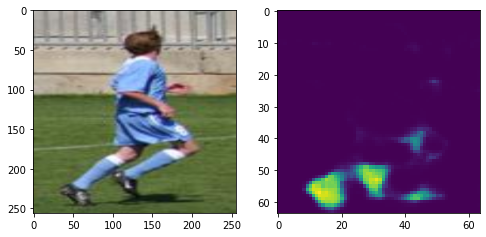

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6436737216128534, 'head_top': 0.9367469879518072, 'neck': 0.9667673716012085, 'shoulder': 0.5908564814814815, 'elbow': 0.5079635949943118, 'wrist': 0.5020126509488212, 'ankle': 0.5642487046632124, 'knee': 0.5922077922077922, 'hip': 0.7586574320724561}
Classification metric 50:
{'all': 0.6437509655492044, 'head_top': 0.9377510040160643, 'neck': 0.9667673716012085, 'shoulder': 0.5908564814814815, 'elbow': 0.5079635949943118, 'wrist': 0.5020126509488212, 'ankle': 0.5642487046632124, 'knee': 0.5922077922077922, 'hip': 0.7586574320724561}
Classification metric 75:
{'all': 0.6437509655492044, 'head_top': 0.9377510040160643, 'neck': 0.9667673716012085, 'shoulder': 0.5908564814814815, 'elbow': 0.5079635949943118, 'wrist': 0.5020126509488212, 'ankle': 0.5642487046632124, 'knee': 0.5922077922077922, 'hip': 0.7586574320724561}
Train Loss on epoch 76: 14.325611881826116
Val Loss on epoch 76: 14.125524759292603


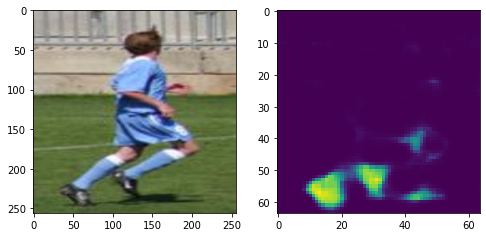

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6421288428858335, 'head_top': 0.9337349397590361, 'neck': 0.9687814702920443, 'shoulder': 0.5891203703703703, 'elbow': 0.5022753128555176, 'wrist': 0.4928119608970673, 'ankle': 0.5642487046632124, 'knee': 0.5953246753246754, 'hip': 0.7607884922749067}
Classification metric 50:
{'all': 0.6421288428858335, 'head_top': 0.9337349397590361, 'neck': 0.9687814702920443, 'shoulder': 0.5891203703703703, 'elbow': 0.5022753128555176, 'wrist': 0.4928119608970673, 'ankle': 0.5642487046632124, 'knee': 0.5953246753246754, 'hip': 0.7607884922749067}
Classification metric 75:
{'all': 0.6421288428858335, 'head_top': 0.9337349397590361, 'neck': 0.9687814702920443, 'shoulder': 0.5891203703703703, 'elbow': 0.5022753128555176, 'wrist': 0.4928119608970673, 'ankle': 0.5642487046632124, 'knee': 0.5953246753246754, 'hip': 0.7607884922749067}
Train Loss on epoch 77: 14.36871455181604
Val Loss on epoch 77: 14.164998054504395


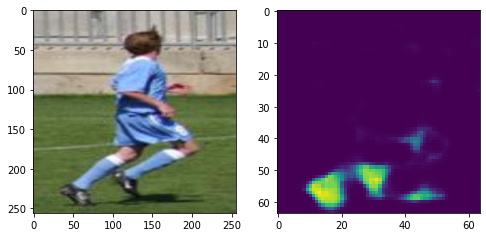

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6413564035223235, 'head_top': 0.9367469879518072, 'neck': 0.9697885196374623, 'shoulder': 0.6006944444444444, 'elbow': 0.5017064846416383, 'wrist': 0.49856239217941345, 'ankle': 0.5595854922279793, 'knee': 0.5833766233766233, 'hip': 0.7549280767181673}
Classification metric 50:
{'all': 0.6414336474586745, 'head_top': 0.9367469879518072, 'neck': 0.9707955689828801, 'shoulder': 0.6006944444444444, 'elbow': 0.5017064846416383, 'wrist': 0.49856239217941345, 'ankle': 0.5595854922279793, 'knee': 0.5833766233766233, 'hip': 0.7549280767181673}
Classification metric 75:
{'all': 0.6414336474586745, 'head_top': 0.9367469879518072, 'neck': 0.9707955689828801, 'shoulder': 0.6006944444444444, 'elbow': 0.5017064846416383, 'wrist': 0.49856239217941345, 'ankle': 0.5595854922279793, 'knee': 0.5833766233766233, 'hip': 0.7549280767181673}
Train Loss on epoch 78: 14.33053338938746
Val Loss on epoch 78: 14.200231075286865


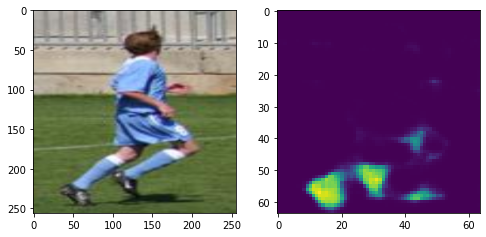

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Classification metric 25:
{'all': 0.6422833307585355, 'head_top': 0.9357429718875502, 'neck': 0.9707955689828801, 'shoulder': 0.5902777777777778, 'elbow': 0.5108077360637088, 'wrist': 0.4997124784358827, 'ankle': 0.5647668393782384, 'knee': 0.5859740259740259, 'hip': 0.7533297815663292}
Classification metric 50:
{'all': 0.6423605746948865, 'head_top': 0.9367469879518072, 'neck': 0.9707955689828801, 'shoulder': 0.5902777777777778, 'elbow': 0.5108077360637088, 'wrist': 0.4997124784358827, 'ankle': 0.5647668393782384, 'knee': 0.5859740259740259, 'hip': 0.7533297815663292}
Classification metric 75:
{'all': 0.6423605746948865, 'head_top': 0.9367469879518072, 'neck': 0.9707955689828801, 'shoulder': 0.5902777777777778, 'elbow': 0.5108077360637088, 'wrist': 0.4997124784358827, 'ankle': 0.5647668393782384, 'knee': 0.5859740259740259, 'hip': 0.7533297815663292}
Train Loss on epoch 79: 14.298555648189852
Val Loss on epoch 79: 14.147221803665161


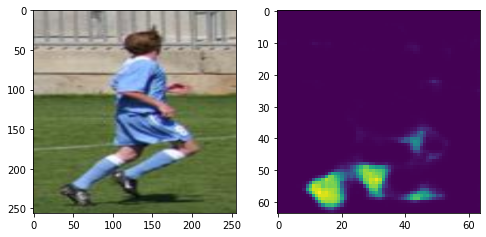

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Classification metric 25:
{'all': 0.6422060868221845, 'head_top': 0.9417670682730924, 'neck': 0.9707955689828801, 'shoulder': 0.5804398148148148, 'elbow': 0.5005688282138794, 'wrist': 0.5066129959746981, 'ankle': 0.5709844559585492, 'knee': 0.5896103896103896, 'hip': 0.7517314864144912}
Classification metric 50:
{'all': 0.6422060868221845, 'head_top': 0.9417670682730924, 'neck': 0.9707955689828801, 'shoulder': 0.5804398148148148, 'elbow': 0.5005688282138794, 'wrist': 0.5066129959746981, 'ankle': 0.5709844559585492, 'knee': 0.5896103896103896, 'hip': 0.7517314864144912}
Classification metric 75:
{'all': 0.6422060868221845, 'head_top': 0.9417670682730924, 'neck': 0.9707955689828801, 'shoulder': 0.5804398148148148, 'elbow': 0.5005688282138794, 'wrist': 0.5066129959746981, 'ankle': 0.5709844559585492, 'knee': 0.5896103896103896, 'hip': 0.7517314864144912}
Train Loss on epoch 80: 14.254976206812366
Val Loss on epoch 80: 14.167068243026733


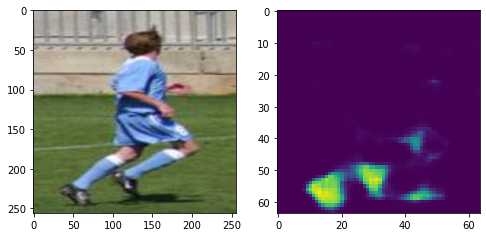

14.167068243026733

In [ ]:
train(train_loader, model, criterion, optimizer, 80, test_set[0][0], sheduler, val_loader, test_loader)

In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [18]:
model = SGSK(15)
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
model = model.eval()

In [46]:
k = 7

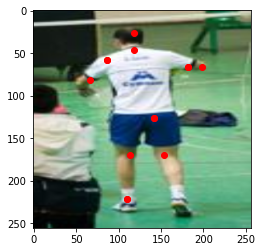

In [49]:
sample = test_set[k]
pred = model(sample[0].unsqueeze(0))
pred_coord = decode_argmax(pred[:, 1:]) * 4 + 2
plt.imshow((sample[0] * 0.3 + 0.3).permute(1, 2, 0).numpy())
plt.scatter(pred_coord[0, :, 0], pred_coord[0, :, 1], c='r')
plt.show()

In [51]:
pred_coord

array([[[110, 222],
        [114, 170],
        [142, 126],
        [142, 126],
        [154, 170],
        [110, 222],
        [198,  66],
        [182,  66],
        [ 86,  58],
        [ 86,  58],
        [182,  66],
        [ 66,  82],
        [118,  46],
        [118,  26]]])

По координатам видно что есть проблема в том что и левую и правую ногу / руку модель иногда определяет в одно и то же место 